In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

import matplotlib.pyplot as plt

In [2]:
from sklearn.base import TransformerMixin, BaseEstimator

class trans_data(BaseEstimator, TransformerMixin):
    
    def __init__(self, column_trans = True):
        self.column_trans = column_trans 

    
    def fit(self,df):
        return self
        
    def transform(self,df):
        mejores = ['sale_3mes', 'qty_3mes', 'tx_3mes',
           'sale_6mes', 'qty_6mes', 'tx_6mes',
           'productos_3mes', 'productos_6mes',
           'dias_p', 'offer_red_3mes',
           'descuento_3mes', 'productos_red_3mes',
           'subdep_red_3mes', 'red_tx_3mes',
           'offer_red_6mes', 'descuento_6mes',
           'productos_red_6mes', 'subdep_red_6mes',
           'red_tx_6mes', 'antiguedad', 'freq_best_prod_3mes',
           'freq_best_prod_6mes', 'qp_6']
        df = trans_data().v_cliente(df)
        df = trans_data().drop_col(df)
        df = df[mejores].copy()
        return df
    
    def target(self, df):
        """Create target or label"""
        df = df.copy().reset_index(drop=True)
        df['churn'] = np.where(df['sale_3mes_mas']< 450, 1,
                               np.where(df['freq_3mes_mas']< .33, 1,
                                        np.where(df['recencia']> 90, 1, 0)))
        return df
    
    def drop_col(self, df):
        cols = ['sale_3mes_mas', 'qty_3mes_mas', 'tx_3mes_mas',
                'freq_3mes_mas','productos_3mes_mas','offer_red_3mes_mas',
                'descuento_3mes_mas','productos_red_3mes_mas',
                'subdep_red_3mes_mas', 'red_tx_3mes_mas',
                'freq_best_prod_3mes_mas','recencia','T',
                'frequency', 'tiendas','nombre','app',
                'web','call_center','sin_datos',
                'contact_flg', 'mail','store','recency']

        df = df.drop(columns=cols).reset_index(drop=True)
        return df
    
    def v_cliente(self, df):
        """Crea Variables de tp y qp del cliente"""
        df = df.copy().reset_index(drop=True)
        df['tp_3'] = round(df['sale_3mes'] / df['tx_3mes'],0)
        df['qp_3'] = round(df['qty_3mes'] / df['tx_3mes'],0)
 
        df['tp_6'] = round(df['sale_6mes'] / df['tx_6mes'],0)
        df['qp_6'] = round(df['qty_6mes'] / df['tx_6mes'],0)
        
        df['tp_3'] = df['tp_3'].fillna(0)
        df['qp_3'] = df['qp_3'].fillna(0)
        df['tp_6'] = df['tp_6'].fillna(0)
        df['qp_6'] = df['qp_6'].fillna(0)
        
        return df
        
    
    def type_features(self, df):
        """Label encoding for categorical and numeric
        , return two lists"""
        #try:
            #df = trans_data().drop_col(df)
        #except:
        #    pass
        cat_list = []
        for colname in df.select_dtypes('object'):
            if colname not in ('id_customer','primera_compra','ult_comp'):
                cat_list.append(colname)

        disc_list = []
        for colname1 in df.select_dtypes(['int64','float64']):
            if colname1 != 'churn':
                disc_list.append(colname1)

        return cat_list,disc_list
    



def selec_periodo(df):
    """ Select specific period"""
    df = df.loc[(df['T']>90) & (df['sale_3mes_mas']>=0) 
                    &(df['sale_3mes']>=0) 
                    & (df['qty_3mes']>=0) 
                    & (df['sale_6mes']>=0) 
                    & (df['qty_6mes']>=0)
                    & (df['tx_6mes']>=6)
                    & (df['sale_6mes']>=0) 
                    & (df['qty_6mes']>=0)
                    & (df['tx_6mes']>=6)
                    & (df['dias_p']<=90)
               ].copy().reset_index(drop=True)
    df = df.loc[(df['primera_compra']<'2019-08-01')].copy().reset_index(drop=True)
    return df

def outliers(df):
    """ Delete rows wich contain outliers"""
    cat_list,disc_list = trans_data().type_features(df)
    df = df[(df[disc_list]>df.quantile(.99)).sum(axis=1)==0].copy().reset_index(drop=True)
    return df
    

In [3]:
class cluster(BaseEstimator, TransformerMixin):
    
    def __init__(self, column_trans = True):
        self.column_trans = column_trans 
    
    def fit(self,df):
        return self
        
    def transform(self,df):
        df = cluster().get_pca(df)
        df = cluster().get_cluster(df)
        return df
    
    def get_pca(self,df):
        from sklearn.decomposition import PCA
        pca_def=PCA(n_components=6)
        pca_def.fit(df) 
        X_pca_def=pca_def.transform(df) 
        cp = pd.DataFrame(X_pca_def)
        return cp
    
    def get_cluster(self,df):
        from sklearn.cluster import KMeans
        cp = cluster().get_pca(df)
        kmeans = KMeans(n_clusters=8).fit(cp)
        labels = kmeans.predict(cp)
        df['label'] = labels
        df = df[['label']]
        X_cd = kmeans.fit_transform(cp)
        X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
        X_cd = scaler.fit_transform(X_cd)
        X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
        df = df.join(X_cd)
        #df = df[['Centroid_6']]
        return df

In [4]:
#Fecha
f_val = '20200630'
final = datetime.strptime(str(f_val), '%Y%m%d').date()
inicio = final - relativedelta(months=12) + relativedelta(days=1)

In [5]:
# Carga del dataset
chu = pd.read_csv(
    '//Users//ibarra//Machine Learning Projects//datasets//base_abandono.csv'
    ,index_col=0)
chu.head()

,id_customer,ult_comp,primera_compra,frequency,sale_3mes_mas,qty_3mes_mas,tx_3mes_mas,freq_3mes_mas,sale_3mes,qty_3mes,...,antiguedad,formato_fav,tipo_freq,meses_comp,freq_best_prod_3mes_mas,freq_best_prod_3mes,freq_best_prod_6mes,recencia,recency,T
0,CONTACTS_3106608,2020-05-08,2019-12-27,14,338.04,16.13,1,0.333333,4874.56,187.04,...,481,3F,quincenal,2,0.000000,1.333333e+00,4.444444e-01,53.0,133.0,186.0
1,CONTACTS_10379819,2020-05-29,2019-11-10,6,1413.95,63.50,5,1.666667,0.00,0.00,...,201,2F,mensual,4,1.333333,3.996803e-15,6.414622e-16,32.0,201.0,233.0
2,CONTACTS_11987867,2020-06-17,2020-01-06,6,5450.73,44.68,4,1.333333,1578.21,40.29,...,286,2F,quincenal,2,0.333333,3.333333e-01,1.111111e-01,13.0,163.0,176.0
3,10000268260,2019-12-10,2019-07-01,108,0.00,0.00,0,0.000000,0.00,0.00,...,342,2F,semanal,6,0.000000,0.000000e+00,2.666667e+00,203.0,162.0,365.0
4,10001203778-1,2020-06-19,2019-12-10,14,7376.72,322.57,8,2.666667,1096.81,27.48,...,192,3F,quincenal,6,1.666667,-4.144833e-15,-6.908054e-16,11.0,192.0,203.0


In [6]:
chu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999808 entries, 0 to 999807
Data columns (total 56 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id_customer              999808 non-null  object 
 1   ult_comp                 999808 non-null  object 
 2   primera_compra           999808 non-null  object 
 3   frequency                999808 non-null  int64  
 4   sale_3mes_mas            999808 non-null  float64
 5   qty_3mes_mas             999808 non-null  float64
 6   tx_3mes_mas              999808 non-null  int64  
 7   freq_3mes_mas            999808 non-null  float64
 8   sale_3mes                999808 non-null  float64
 9   qty_3mes                 999808 non-null  float64
 10  tx_3mes                  999808 non-null  int64  
 11  freq_3mes                999808 non-null  float64
 12  sale_6mes                999808 non-null  float64
 13  qty_6mes                 999808 non-null  float64
 14  tx_6

In [7]:
chu = selec_periodo(chu)

In [8]:
chu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324133 entries, 0 to 324132
Data columns (total 56 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id_customer              324133 non-null  object 
 1   ult_comp                 324133 non-null  object 
 2   primera_compra           324133 non-null  object 
 3   frequency                324133 non-null  int64  
 4   sale_3mes_mas            324133 non-null  float64
 5   qty_3mes_mas             324133 non-null  float64
 6   tx_3mes_mas              324133 non-null  int64  
 7   freq_3mes_mas            324133 non-null  float64
 8   sale_3mes                324133 non-null  float64
 9   qty_3mes                 324133 non-null  float64
 10  tx_3mes                  324133 non-null  int64  
 11  freq_3mes                324133 non-null  float64
 12  sale_6mes                324133 non-null  float64
 13  qty_6mes                 324133 non-null  float64
 14  tx_6

In [9]:
chu['tx_3mes'].describe()

count    324133.000000
mean          9.984633
std           9.703423
min           0.000000
25%           4.000000
50%           7.000000
75%          13.000000
max          91.000000
Name: tx_3mes, dtype: float64

In [10]:
chu['tx_3mes'].loc[chu['sale_3mes']>0].describe()

count    308843.000000
mean         10.478874
std           9.676738
min           1.000000
25%           4.000000
50%           8.000000
75%          13.000000
max          91.000000
Name: tx_3mes, dtype: float64

In [11]:
chu['sale_3mes'].describe()

count    324133.000000
mean       4404.937068
std        6524.446493
min           0.000000
25%        1128.290000
50%        2816.590000
75%        5782.810000
max      576134.040000
Name: sale_3mes, dtype: float64

In [12]:
chu['sale_3mes'].sum()/chu['tx_3mes'].sum()

441.17166183560545

In [13]:
chu['sale_3mes'].loc[chu['dias_p']<31].sum()/chu['tx_3mes'].loc[chu['dias_p']<31].sum()

440.946424780038

In [14]:
chu['tx_6mes'].describe()

count    324133.000000
mean         18.670191
std          15.912452
min           6.000000
25%           9.000000
50%          14.000000
75%          22.000000
max         181.000000
Name: tx_6mes, dtype: float64

In [15]:
chu['sale_6mes'].describe()

count    3.241330e+05
mean     8.998237e+03
std      1.192978e+04
min      1.475000e+01
25%      3.154370e+03
50%      6.121340e+03
75%      1.137916e+04
max      1.646669e+06
Name: sale_6mes, dtype: float64

In [16]:
chu['sale_6mes'].sum()/chu['tx_6mes'].sum()

481.9574427166257

In [17]:
chu['sale_6mes'].loc[chu['dias_p']<31].sum()/chu['tx_6mes'].loc[chu['dias_p']<31].sum()

481.554630089148

<AxesSubplot:>

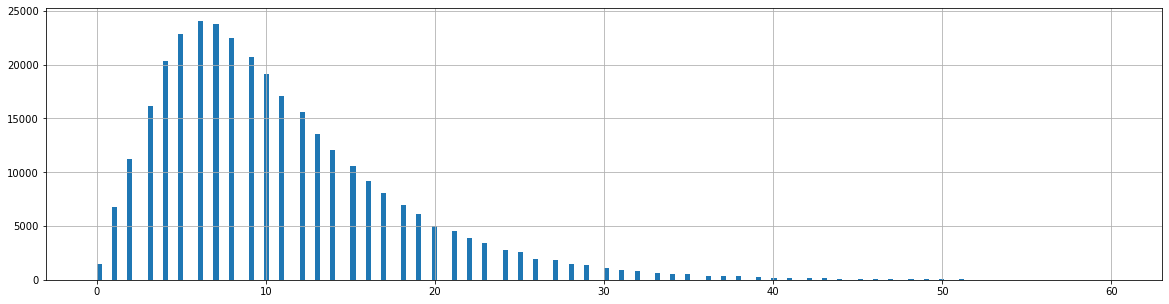

In [18]:
chu['dias_p'].hist(bins=200,figsize=(20,5))

<AxesSubplot:xlabel='meses_comp'>

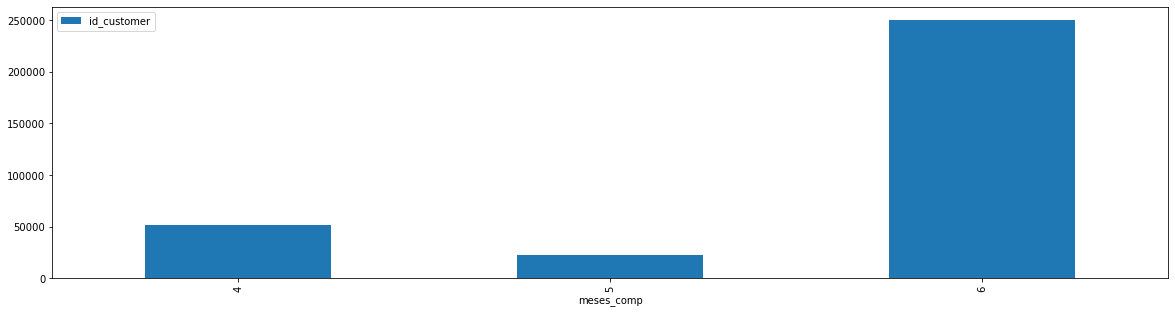

In [19]:
chu.groupby(['meses_comp']).agg({'id_customer':'count'}).plot(kind='bar',figsize=(20,5))

<AxesSubplot:>

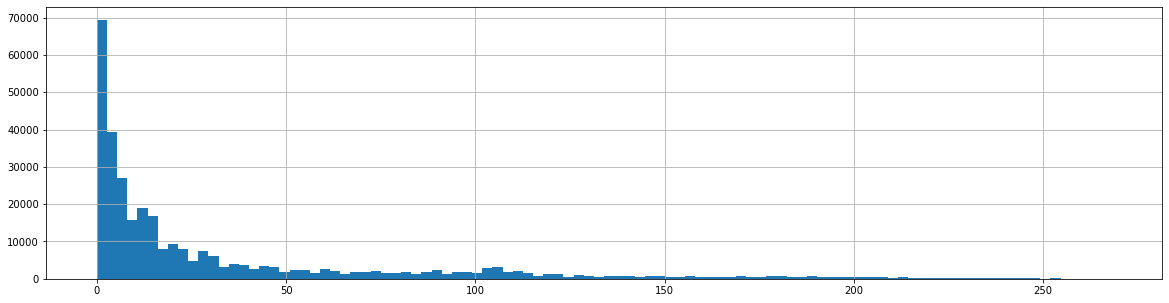

In [20]:
chu['recencia'].hist(bins=100,figsize=(20,5))

<AxesSubplot:>

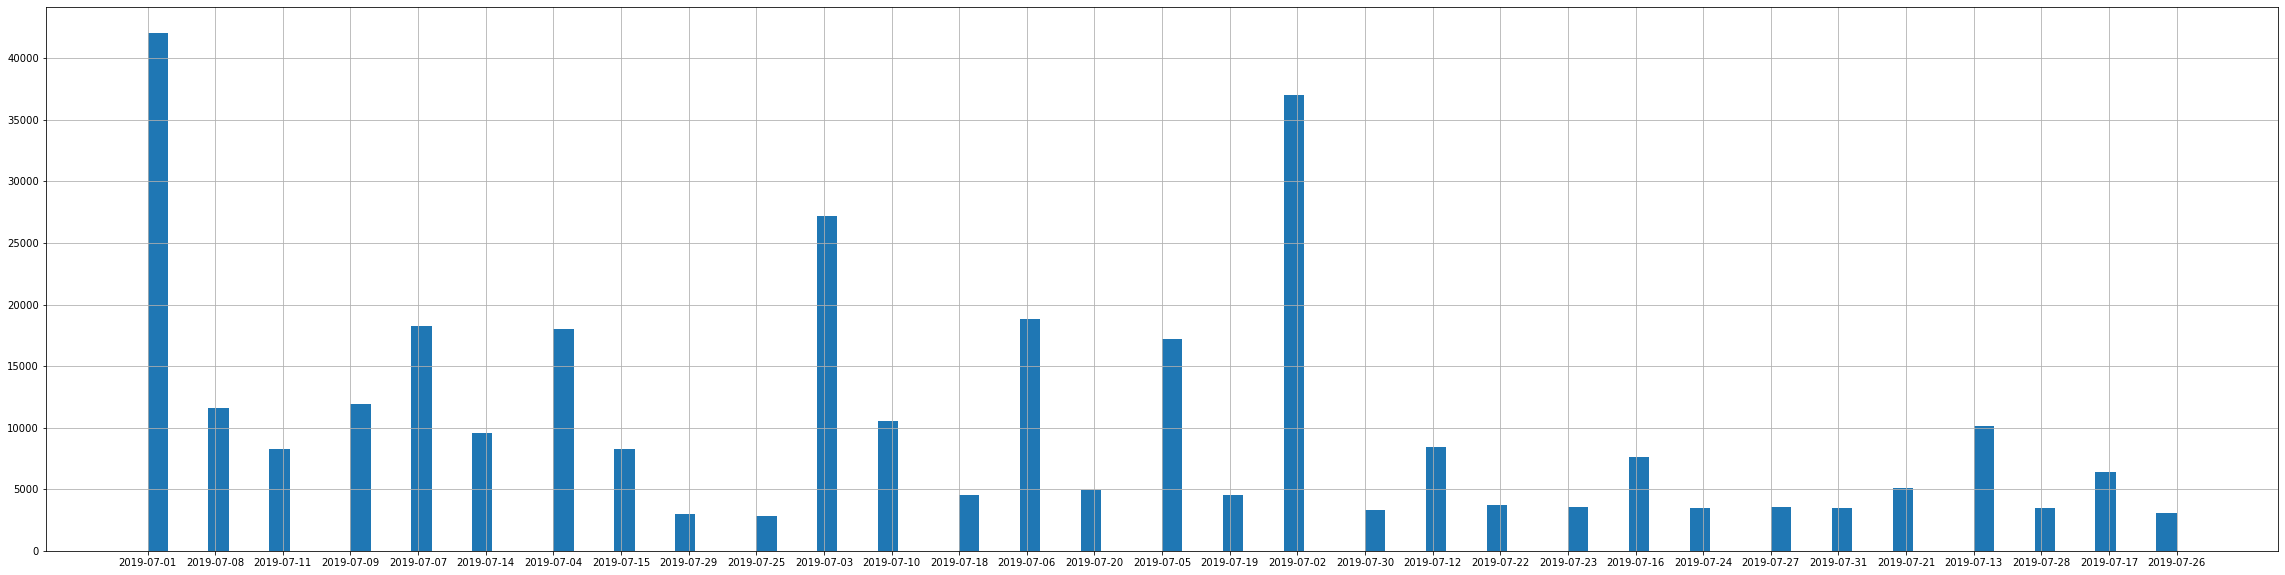

In [21]:
chu['primera_compra'].hist(bins=100,figsize=(40,10))

<AxesSubplot:>

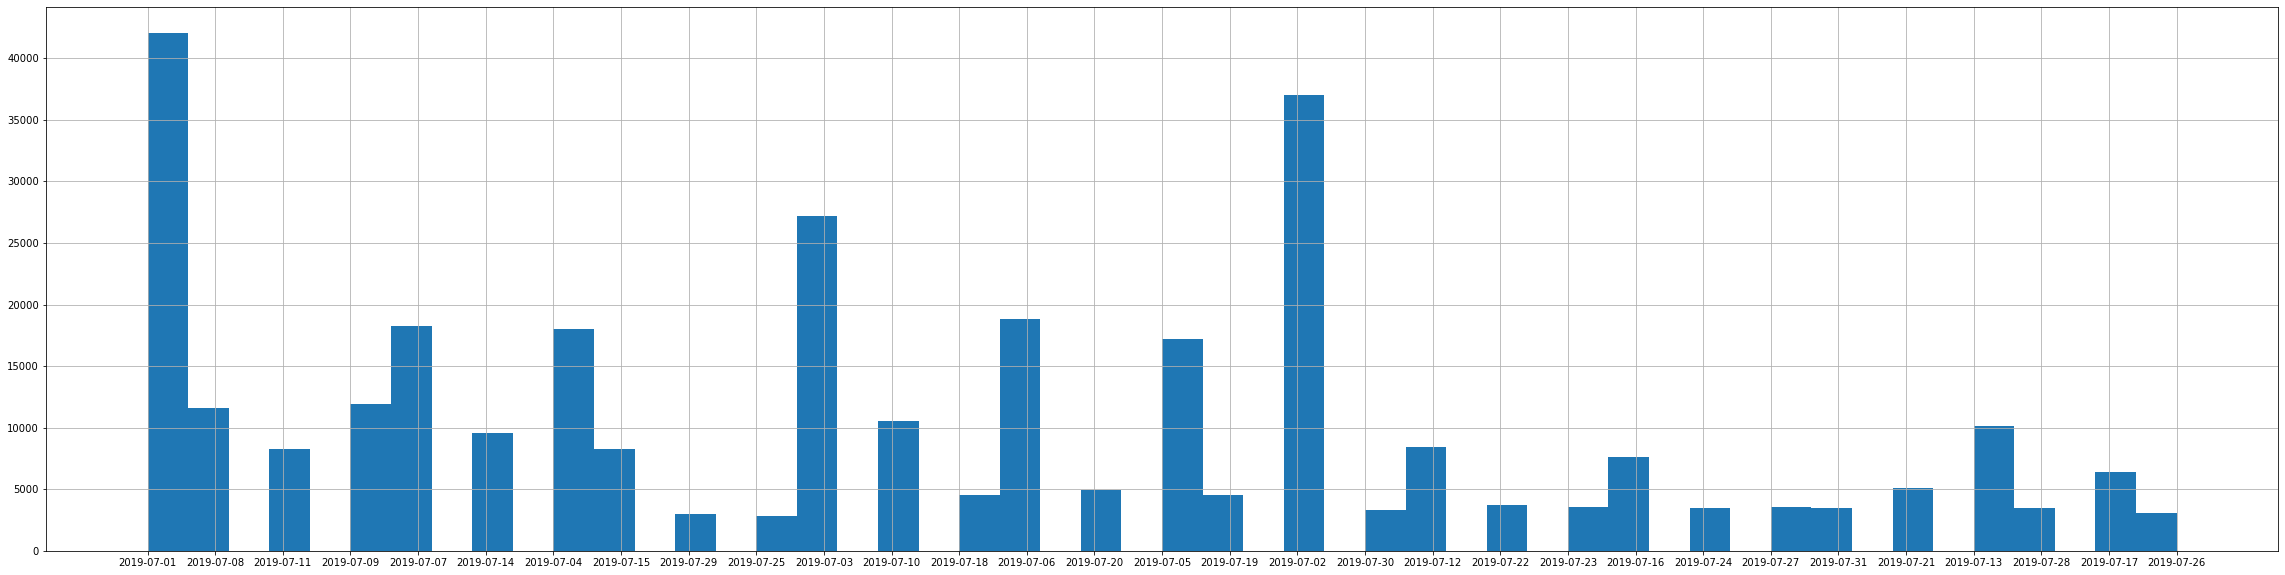

In [22]:
chu['primera_compra'].loc[chu['primera_compra']<'2019-08-01'].hist(bins=50,figsize=(40,10))

<AxesSubplot:>

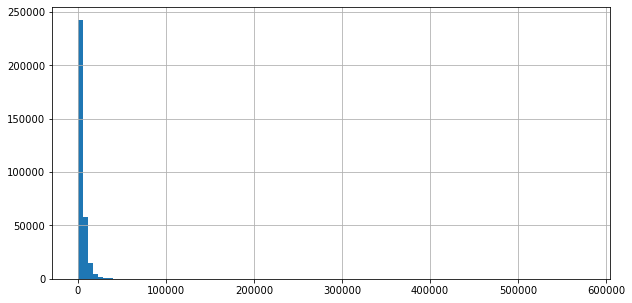

In [23]:
chu['sale_3mes'].hist(bins=100,figsize=(10,5))

<AxesSubplot:>

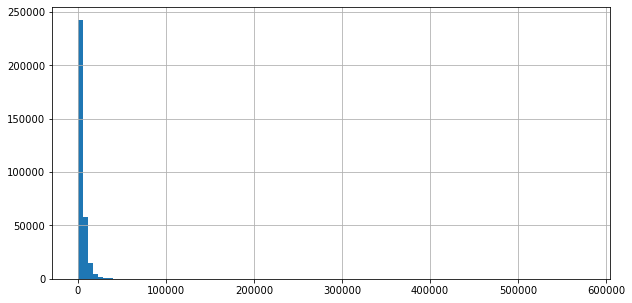

In [24]:
chu['sale_3mes'].loc[chu['primera_compra']<'2019-08-01'].hist(bins=100
                                                            ,figsize=(10,5))

<AxesSubplot:>

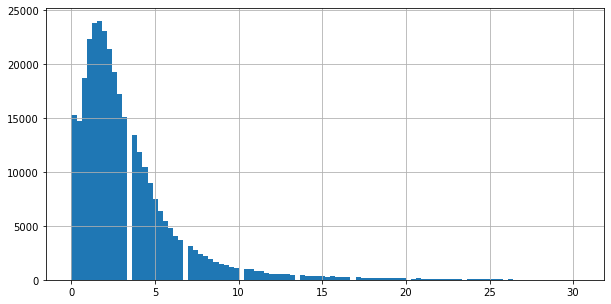

In [25]:
chu['freq_3mes'].loc[chu['primera_compra']<'2019-08-01'].hist(bins=100
                                                            ,figsize=(10,5))

In [26]:
from sklearn.model_selection import train_test_split
chu_train, chu_test = train_test_split(chu, test_size=0.3 
                                       , random_state=42)
chu_train.shape, chu_test.shape

((226893, 56), (97240, 56))

In [27]:
chu_test, chu_val = train_test_split(chu_test, test_size=0.3 
                                     , random_state=42)
chu_test.shape, chu_val.shape

((68068, 56), (29172, 56))

In [28]:
chu_train.describe()

,frequency,sale_3mes_mas,qty_3mes_mas,tx_3mes_mas,freq_3mes_mas,sale_3mes,qty_3mes,tx_3mes,freq_3mes,sale_6mes,...,mail,nombre,antiguedad,meses_comp,freq_best_prod_3mes_mas,freq_best_prod_3mes,freq_best_prod_6mes,recencia,recency,T
count,226893.000000,226893.000000,226893.00000,226893.000000,226893.000000,226893.000000,226893.00000,226893.000000,226893.000000,2.268930e+05,...,226893.000000,226893.000000,226893.000000,226893.000000,226893.000000,2.268930e+05,2.268930e+05,226893.000000,226893.000000,226893.000000
mean,47.763430,3815.720634,145.55178,7.087164,2.362388,4387.692085,172.69557,9.955270,3.318423,8.991432e+03,...,0.212475,0.003336,753.171627,5.613073,1.011828,1.394715e+00,9.764642e-01,33.822079,322.984275,356.806354
std,66.994928,5669.348773,206.88462,8.220343,2.740114,6294.749528,243.29203,9.665457,3.221819,1.198680e+04,...,0.409060,0.057665,167.012319,0.745070,1.386725,1.671768e+00,1.046997e+00,48.571473,49.446356,7.996909
min,7.000000,0.000000,-0.95000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.475000e+01,...,0.000000,0.000000,79.000000,4.000000,0.000000,-3.907985e-14,-7.105427e-15,0.000000,74.000000,335.000000
25%,22.000000,619.500000,24.00000,2.000000,0.666667,1119.580000,45.00000,4.000000,1.333333,3.147140e+03,...,0.000000,0.000000,691.000000,6.000000,0.000000,3.333333e-01,4.444444e-01,3.000000,313.000000,352.000000
50%,34.000000,2219.810000,87.63000,5.000000,1.666667,2807.370000,113.28000,7.000000,2.333333,6.107600e+03,...,0.000000,0.000000,826.000000,6.000000,0.666667,1.000000e+00,6.666667e-01,12.000000,342.000000,359.000000
75%,55.000000,5124.490000,200.29000,9.000000,3.000000,5769.150000,229.45000,13.000000,4.333333,1.137907e+04,...,0.000000,0.000000,877.000000,6.000000,1.333333,2.000000e+00,1.222222e+00,42.000000,355.000000,363.000000
max,18083.000000,603837.540000,24127.36000,90.000000,30.000000,576134.040000,23860.77000,91.000000,30.333333,1.646669e+06,...,1.000000,1.000000,894.000000,6.000000,26.666667,2.833333e+01,1.933333e+01,268.000000,365.000000,365.000000


In [29]:
chu_train = trans_data().target(chu_train)
chu_train = trans_data().v_cliente(chu_train)
chu_train = outliers(chu_train)
chu_train = trans_data().drop_col(chu_train)

/var/folders/mm/nyjyv2yn1w12b15s5x1psy5r0000gn/T/ipykernel_4607/3030134468.py:107: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[(df[disc_list]>df.quantile(.99)).sum(axis=1)==0].copy().reset_index(drop=True)


In [30]:
chu_train.shape

(193552, 37)

In [31]:
chu_train['churn'].value_counts()

0    149976
1     43576
Name: churn, dtype: int64

<AxesSubplot:>

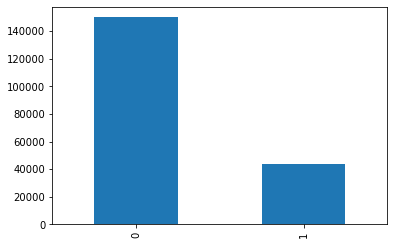

In [32]:
chu_train['churn'].value_counts().plot(kind='bar')

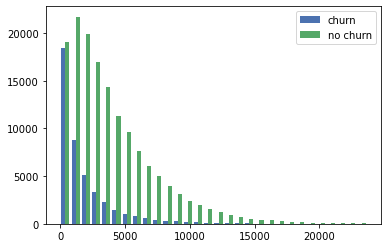

In [33]:
#chu_train['sale_6mes'].loc[chu_train['churn']==1].hist(bins=100)

plt.style.use('seaborn-deep')

x = chu_train['sale_3mes'].loc[chu_train['churn']==1]
y = chu_train['sale_3mes'].loc[chu_train['churn']==0]
#bins = np.linspace(-10, 10, 30)

plt.hist([x, y], 30, label=['churn', 'no churn'])
plt.legend(loc='upper right')
plt.show()

<AxesSubplot:>

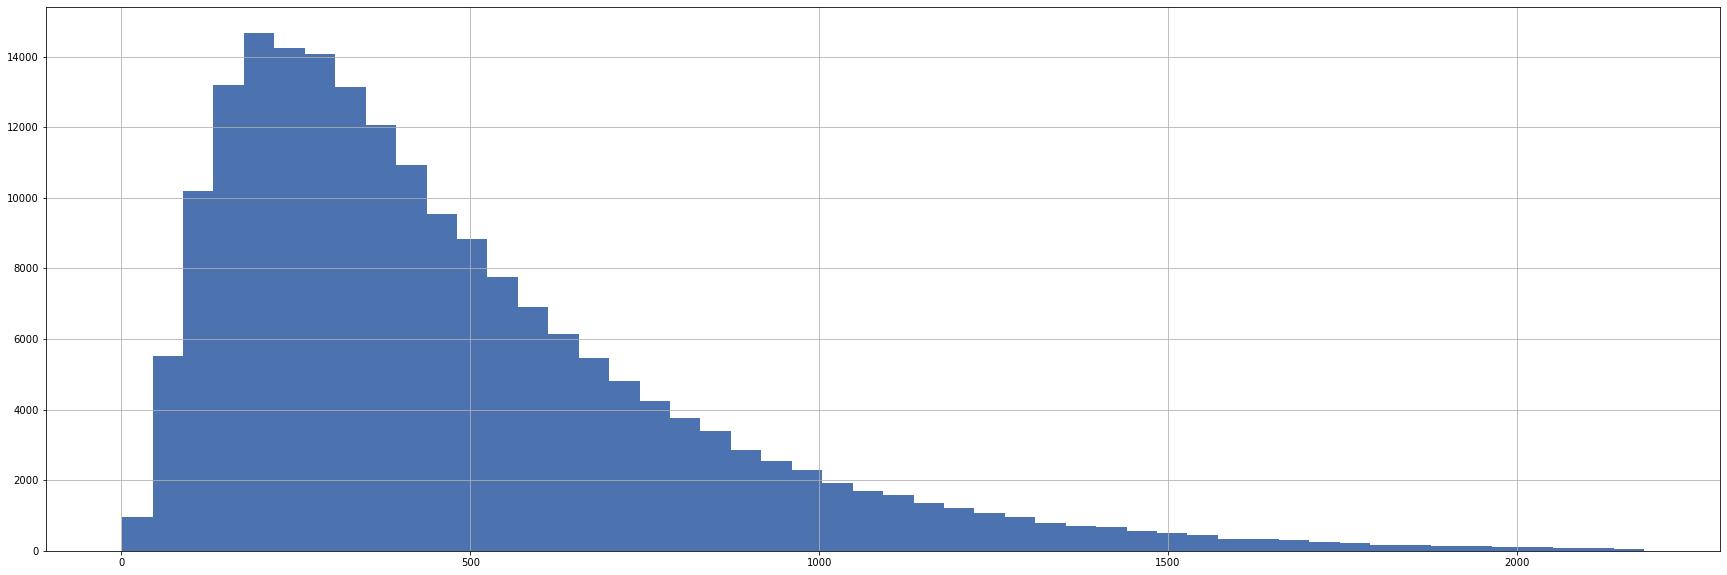

In [34]:
chu_train['tp_6'].hist(bins=50,figsize=(30,10))

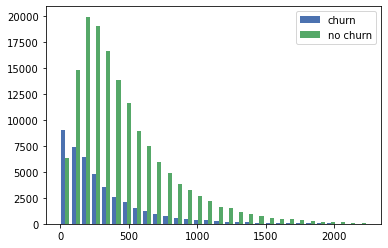

In [35]:
plt.style.use('seaborn-deep')

x = chu_train['tp_3'].loc[chu_train['churn']==1]
y = chu_train['tp_3'].loc[chu_train['churn']==0]
#bins = np.linspace(-10, 10, 30)

plt.hist([x, y], 30, label=['churn', 'no churn'])
plt.legend(loc='upper right')
plt.show()

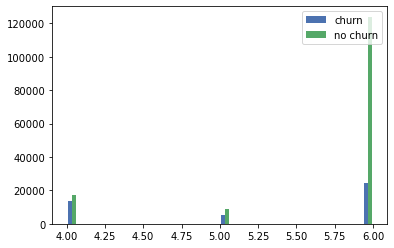

In [36]:
plt.style.use('seaborn-deep')

x = chu_train['meses_comp'].loc[chu_train['churn']==1]
y = chu_train['meses_comp'].loc[chu_train['churn']==0]
#bins = np.linspace(-10, 10, 30)

plt.hist([x, y], 30, label=['churn', 'no churn'])
plt.legend(loc='upper right')
plt.show()

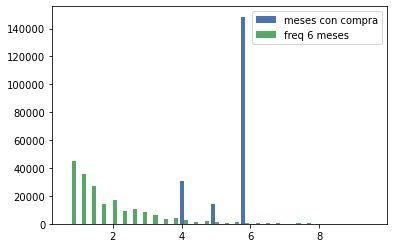

In [37]:
plt.style.use('seaborn-deep')

x = chu_train['meses_comp']
y = chu_train['freq_6mes']
#bins = np.linspace(-10, 10, 30)

plt.hist([x, y], 30, label=['meses con compra', 'freq 6 meses'])
plt.legend(loc='upper right')
plt.show()

In [38]:
cat_list,disc_list = trans_data().type_features(chu_train)

In [39]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(chu_train[disc_list], chu_train['churn'])
mi_scores[::3]  # show a few features with their MI scores

productos_6mes         0.119170
antiguedad             0.089367
qty_3mes               0.062038
freq_6mes              0.052460
offer_red_3mes         0.043754
freq_3mes              0.042007
productos_3mes         0.038247
productos_red_3mes     0.037201
freq_best_prod_3mes    0.033429
telefono               0.025374
dias_p                 0.003655
Name: MI Scores, dtype: float64

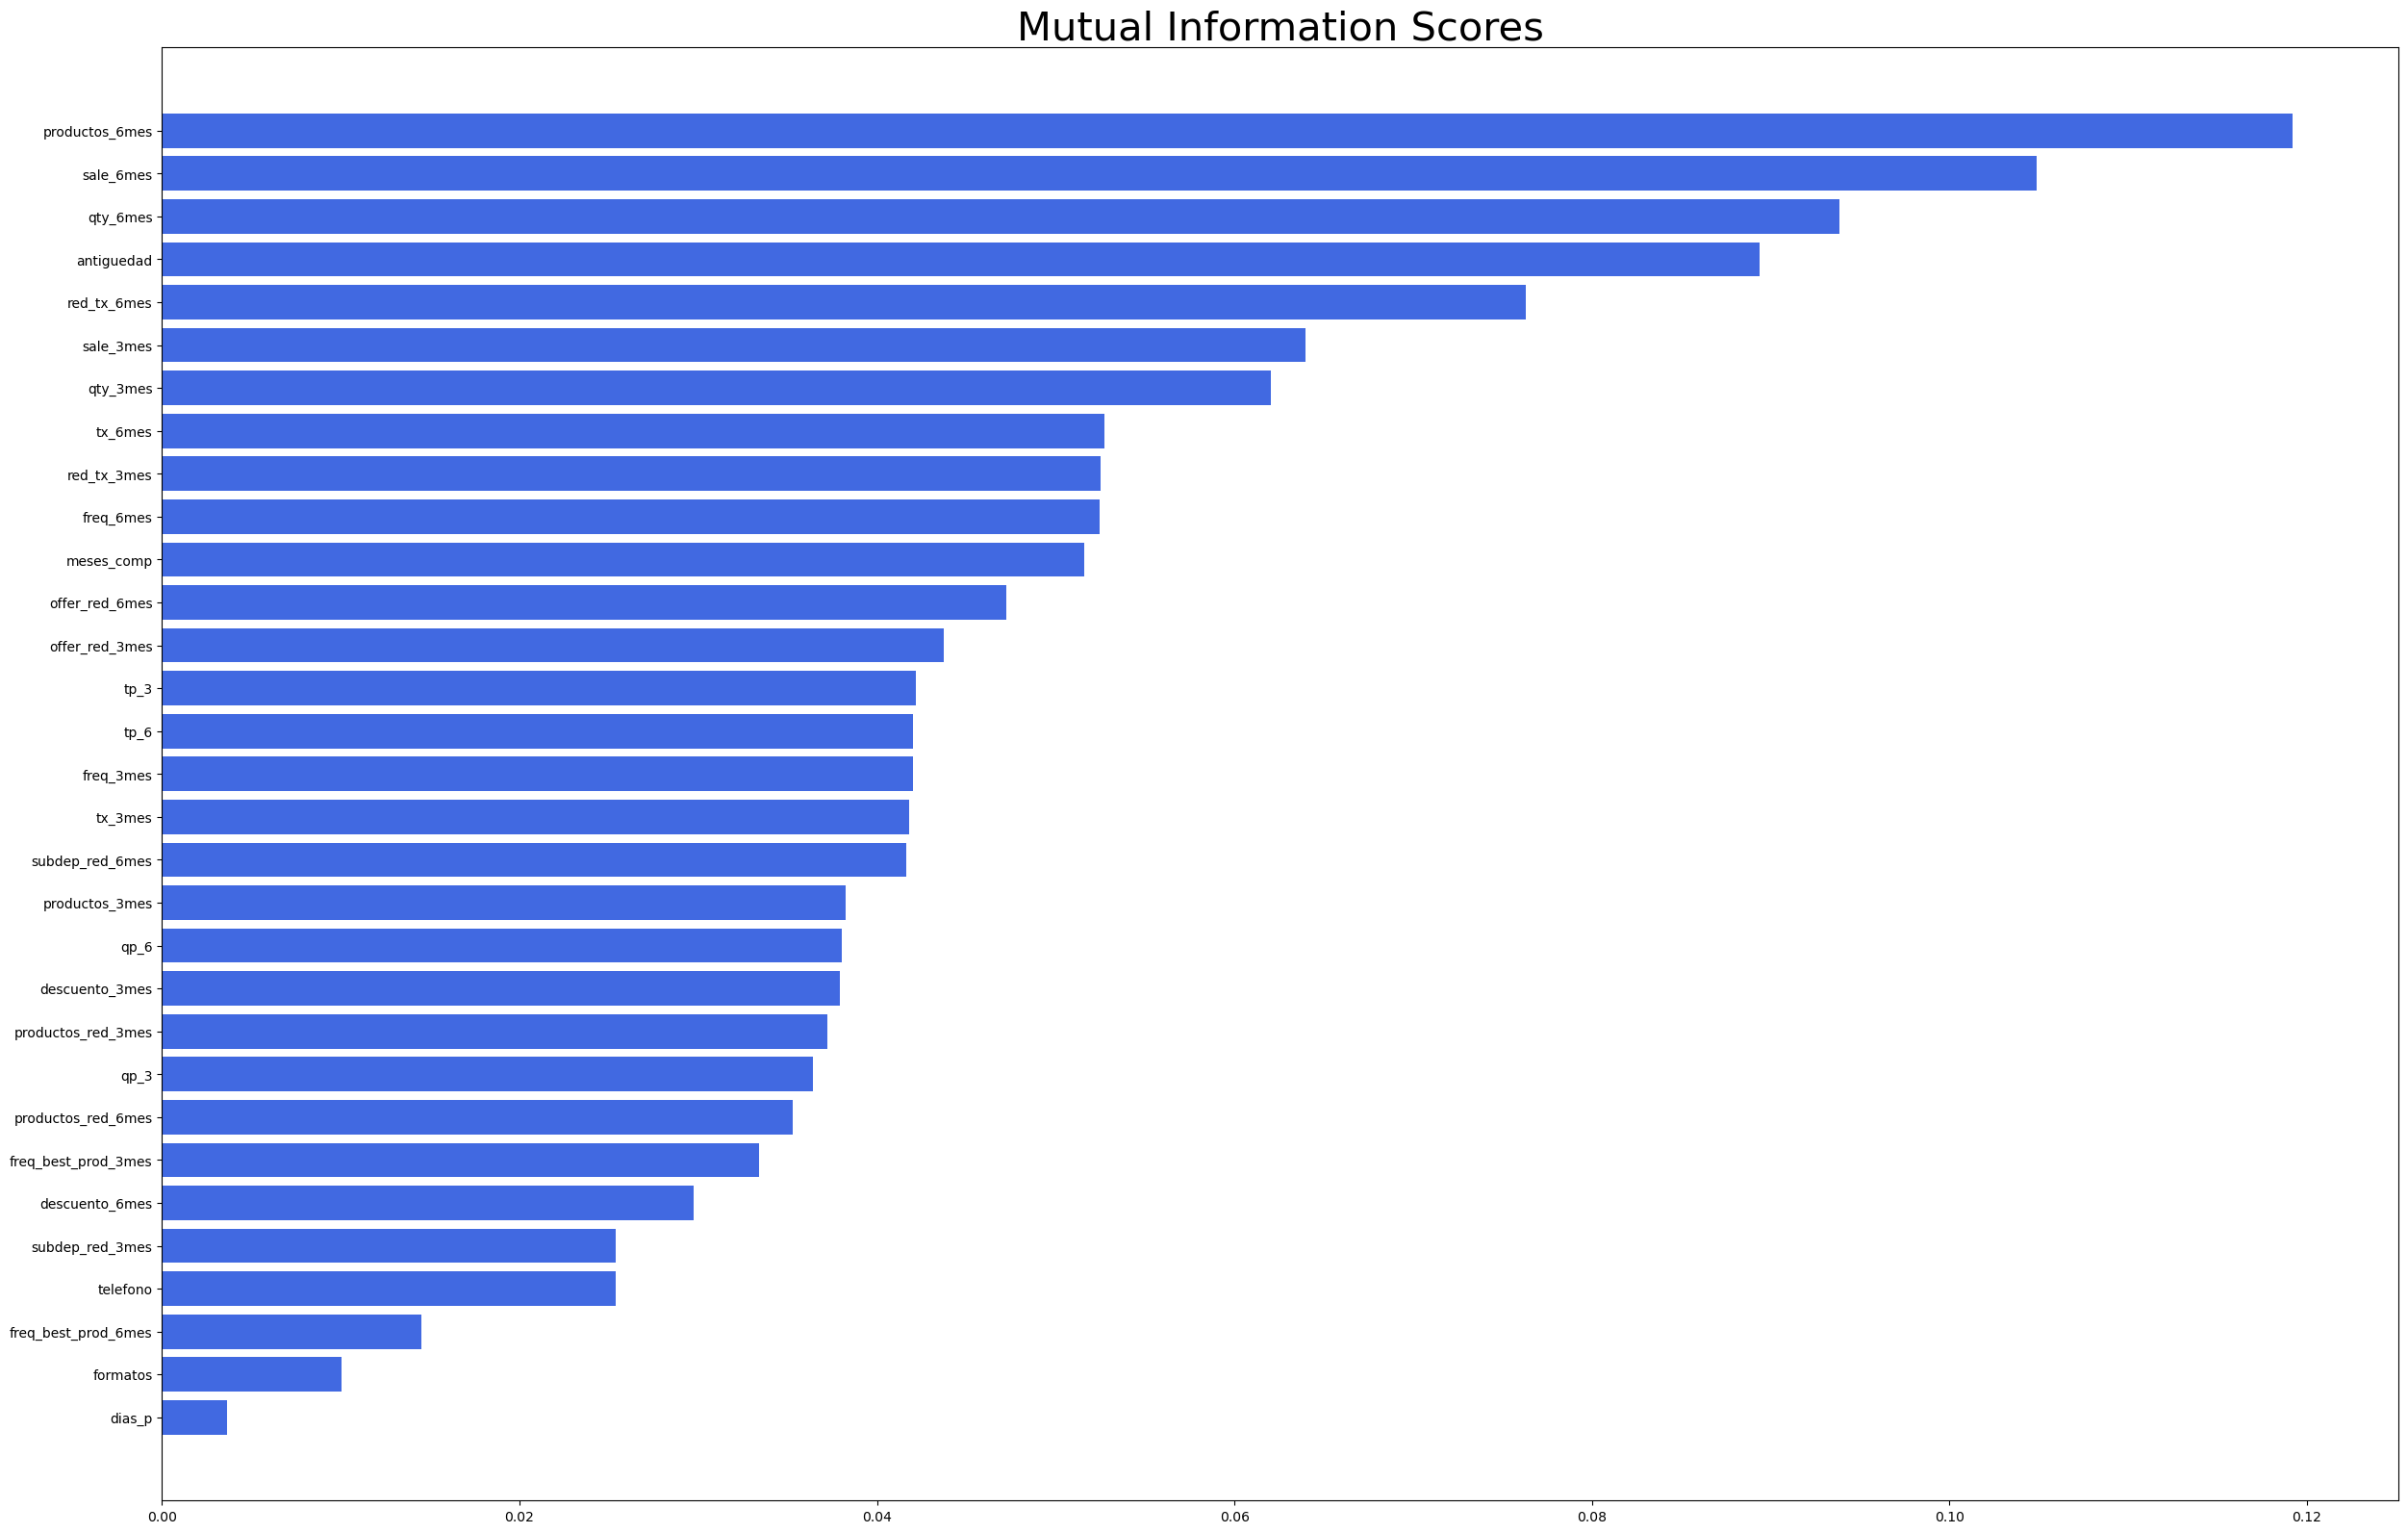

In [40]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores,color='royalblue')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores", fontsize=30)


plt.figure(dpi=100, figsize=(30, 20))
plot_mi_scores(mi_scores)

In [41]:
chu_train.columns

Index(['id_customer', 'ult_comp', 'primera_compra', 'sale_3mes', 'qty_3mes',
       'tx_3mes', 'freq_3mes', 'sale_6mes', 'qty_6mes', 'tx_6mes', 'freq_6mes',
       'formatos', 'productos_3mes', 'productos_6mes', 'dias_p',
       'offer_red_3mes', 'descuento_3mes', 'productos_red_3mes',
       'subdep_red_3mes', 'red_tx_3mes', 'offer_red_6mes', 'descuento_6mes',
       'productos_red_6mes', 'subdep_red_6mes', 'red_tx_6mes', 'telefono',
       'antiguedad', 'formato_fav', 'tipo_freq', 'meses_comp',
       'freq_best_prod_3mes', 'freq_best_prod_6mes', 'churn', 'tp_3', 'qp_3',
       'tp_6', 'qp_6'],
      dtype='object')

Text(0, 0.5, 'Clientes')

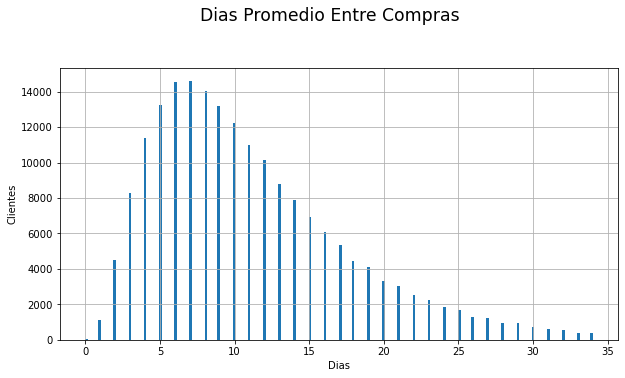

In [42]:
chu_train['dias_p'].hist(bins=200,figsize=(10,5),color='tab:blue')
plt.suptitle('Dias Promedio Entre Compras', x=0.5, y=1.05, ha='center', fontsize='xx-large')
plt.xlabel('Dias')
plt.ylabel('Clientes')

<AxesSubplot:xlabel='churn'>

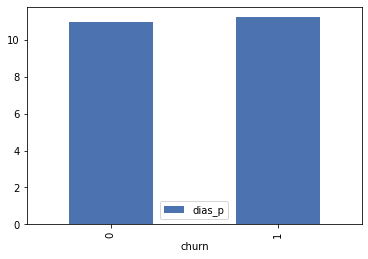

In [43]:
chu_train.groupby('churn').agg({'dias_p':'mean'}).plot(kind='bar')

In [44]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
formato_cat = cat_encoder.fit_transform(chu_train[cat_list])
formato_cat.toarray()
cat_encoder.categories_

nombres=[]
for name in cat_encoder.categories_:
    for x in name:
        nombres.append(x)
nombres

['1F',
 '2F',
 '3F',
 '4F',
 '5F',
 '6F',
 '7F',
 '8F',
 'mensual',
 'quincenal',
 'semanal']

In [45]:
formatos = pd.DataFrame(data=formato_cat.toarray()
                        ,columns=nombres)
formatos.head()

,1F,2F,3F,4F,5F,6F,7F,8F,mensual,quincenal,semanal
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
chu_train = chu_train.drop(columns=cat_list).reset_index(drop=True).join(formatos)
chu_train

,id_customer,ult_comp,primera_compra,sale_3mes,qty_3mes,tx_3mes,freq_3mes,sale_6mes,qty_6mes,tx_6mes,...,2F,3F,4F,5F,6F,7F,8F,mensual,quincenal,semanal
0,CONTACTS_5775383,2020-06-11,2019-07-02,1851.66,70.85,6,2.000000,3583.50,192.50,15,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,CONTACTS_7034535,2020-03-02,2019-07-11,19.40,1.00,1,0.333333,790.30,71.91,13,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,10000314255,2020-06-29,2019-07-21,1799.16,73.11,6,2.000000,3440.93,99.68,9,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,10002085550,2020-06-24,2019-07-07,11186.11,427.43,12,4.000000,31641.62,1142.34,34,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,10000279726,2020-06-30,2019-07-11,1367.44,70.78,10,3.333333,6266.20,324.17,25,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193547,10001559094,2020-06-26,2019-07-03,319.55,9.84,2,0.666667,2525.77,92.62,11,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
193548,10002510709,2020-06-29,2019-07-11,0.00,0.00,0,0.000000,3291.23,392.42,13,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
193549,10004391198,2020-03-30,2019-07-03,2526.87,169.46,7,2.333333,7285.81,315.39,8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
193550,10004615892,2020-06-30,2019-07-01,4381.47,135.01,18,6.000000,6072.65,188.43,28,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
corr_matrix = chu_train.corr()
corr_matrix['churn'].sort_values(ascending=False)

churn                  1.000000
mensual                0.049337
red_tx_3mes            0.035121
4F                     0.035085
7F                     0.035006
8F                     0.026879
1F                     0.024274
6F                     0.016900
dias_p                 0.014596
5F                     0.005314
quincenal             -0.008925
2F                    -0.013886
3F                    -0.026152
telefono              -0.039702
semanal               -0.040845
formatos              -0.048022
freq_best_prod_6mes   -0.083384
descuento_6mes        -0.089381
subdep_red_3mes       -0.091092
descuento_3mes        -0.093426
productos_red_3mes    -0.165077
productos_red_6mes    -0.179928
tp_3                  -0.184643
qp_3                  -0.194241
freq_best_prod_3mes   -0.199029
tp_6                  -0.201782
productos_3mes        -0.206567
qp_6                  -0.210784
freq_3mes             -0.220432
tx_3mes               -0.220432
subdep_red_6mes       -0.235404
offer_re

In [48]:
from sklearn.preprocessing import StandardScaler
list_scaler = ['churn','id_customer','1F'
               ,'2F','3F','4F','5F','6F'
               ,'7F','8F','mensual','quincenal'
               ,'semanal','ult_comp','primera_compra']


scaler = StandardScaler()
scaled = scaler.fit_transform(chu_train.drop(columns=list_scaler))
scaled  = pd.DataFrame(scaled,columns=chu_train.drop(columns=list_scaler).columns)
scaled = scaled.join(chu_train[nombres])
scaled.head()

,sale_3mes,qty_3mes,tx_3mes,freq_3mes,sale_6mes,qty_6mes,tx_6mes,freq_6mes,formatos,productos_3mes,...,2F,3F,4F,5F,6F,7F,8F,mensual,quincenal,semanal
0,-0.490123,-0.525705,-0.393084,-0.393084,-0.616129,-0.377343,-0.139627,-0.139627,-0.880216,-0.115615,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.045020,-1.072292,-1.099931,-1.099931,-1.091738,-0.925679,-0.322709,-0.322709,-0.880216,-1.286092,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,-0.506023,-0.508020,-0.393084,-0.393084,-0.640405,-0.799406,-0.688873,-0.688873,0.341232,0.024842,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.336798,2.264587,0.455132,0.455132,4.161437,3.941683,1.599653,1.599653,-0.880216,1.078272,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.636768,-0.526253,0.172394,0.172394,-0.159335,0.221375,0.775783,0.775783,0.341232,-0.466758,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Cluster

In [49]:
feat_clus = ['sale_3mes', 'qty_3mes', 'tx_3mes', 'freq_3mes','productos_3mes','offer_red_3mes', 'descuento_3mes',
       'productos_red_3mes', 'subdep_red_3mes', 'red_tx_3mes','freq_best_prod_3mes']

## Componentes Principales

In [50]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn.decomposition import PCA

In [51]:
#Instanciamos objeto PCA y aplicamos
pca=PCA(n_components=11)

In [52]:
pca.fit(scaled[feat_clus])
X_pca=pca.transform(scaled[feat_clus])

In [53]:
print("shape of X_pca", X_pca.shape)
expl = pca.explained_variance_ratio_
print(expl)
print('suma:',sum(expl[0:5]))

shape of X_pca (193552, 11)
[5.48760086e-01 1.49869678e-01 7.77625225e-02 6.88977286e-02
 5.41142647e-02 3.42163911e-02 2.92551623e-02 1.60009388e-02
 1.19947944e-02 9.12843420e-03 1.38912318e-33]
suma: 0.8994042793041745


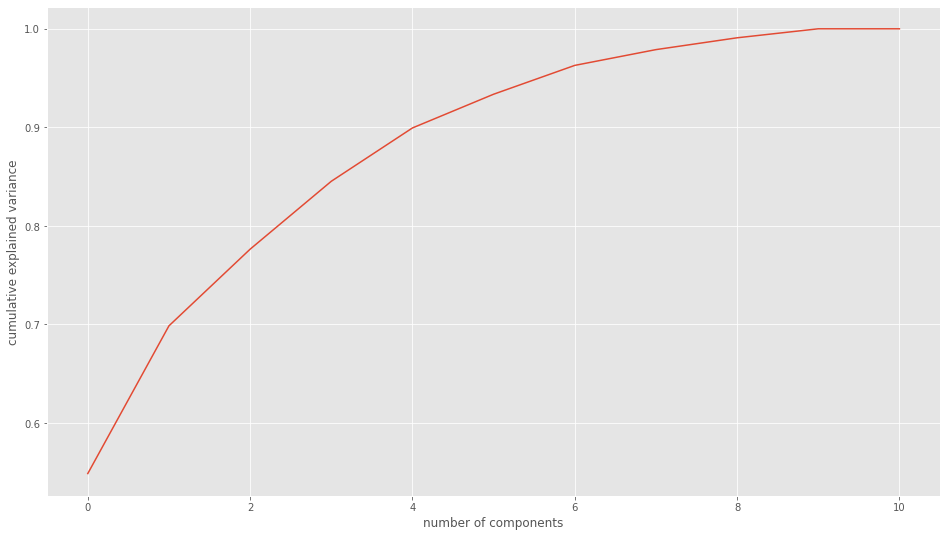

In [54]:
#graficamos el acumulado de varianza explicada en las nuevas dimensiones
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [55]:
#Instanciamos objeto PCA y aplicamos
pca_def=PCA(n_components=6)

In [56]:
pca_def.fit(scaled[feat_clus]) 
X_pca_def=pca_def.transform(scaled[feat_clus]) 

In [57]:
cp = pd.DataFrame(X_pca_def)
cp.head()

,0,1,2,3,4,5
0,-1.194398,-0.362649,-0.163854,-0.117714,0.123650,-0.229073
1,-3.087695,0.379148,-0.091062,0.040083,0.194815,-0.138443
2,-1.809446,-0.779468,0.683000,-0.565801,-0.474200,0.143831
3,4.396287,1.884384,1.079846,-1.030687,-0.716949,-0.967581
4,-0.396499,0.118113,-0.786686,0.875695,0.300867,0.308391


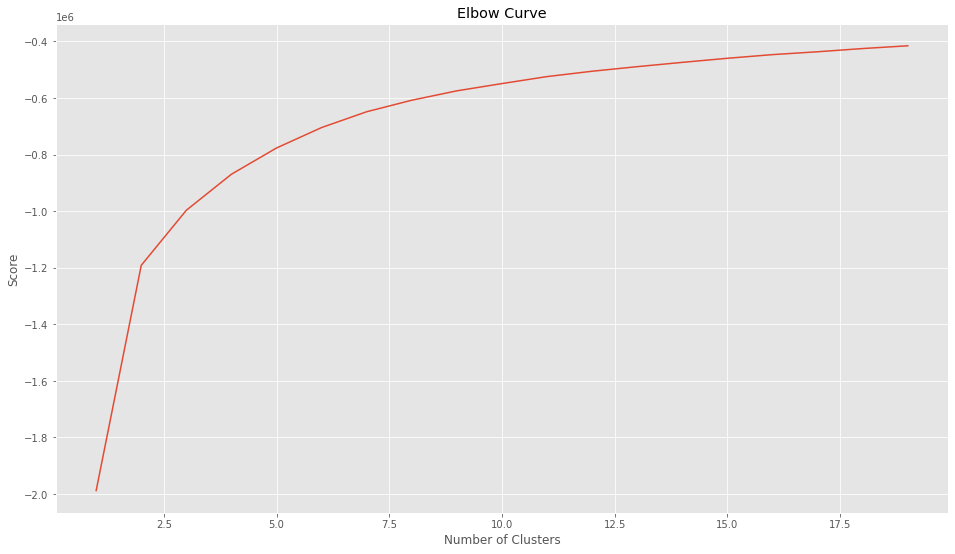

In [58]:
#Obtener el valor de k
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(cp).score(cp) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [59]:
kmeans = KMeans(n_clusters=8).fit(cp)
centroids = kmeans.cluster_centers_
print(centroids)

[[ 3.6363922   3.48591861  4.61010449  0.98230946  2.63438203  0.18799165]
 [-0.32054054 -0.88934238  0.25026581 -0.02907562 -0.09360759  0.03822313]
 [ 5.69641898  0.11814141 -0.56707278 -0.86257012  0.3289044  -0.18979744]
 [-0.15324237  0.71030649 -0.46073471  0.22678222  0.04102789  0.07629101]
 [-2.31173557  0.09770552  0.03854569 -0.04296967  0.04458876 -0.05329915]
 [ 2.86861513  2.12492279 -0.07953817  0.52462279 -1.24449678 -0.07606771]
 [ 2.053637   -0.25171332 -0.35010188 -0.67266104  0.23729869  0.09764582]
 [ 3.34396215 -2.75787525  0.33988272  1.12636281 -0.09505678 -0.00866207]]


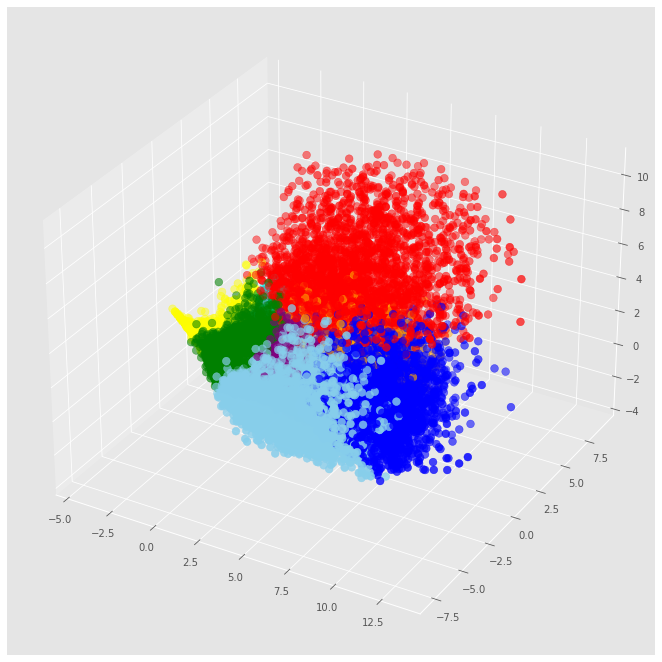

In [62]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

# Predicting the clusters
labels = kmeans.predict(cp)
# Getting the cluster centers
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow','orange','purple','skyblue']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig,auto_add_to_figure=False)
fig.add_axes(ax)
ax.scatter(np.array(cp)[:, 0], np.array(cp)[:, 1], np.array(cp)[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [63]:
scaled['label'] = labels

In [64]:
X_cd = kmeans.fit_transform(cp)
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
X_cd = scaler.fit_transform(X_cd)
X_cd = pd.DataFrame(X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])])
scaled = scaled.join(X_cd)

In [65]:
scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193552 entries, 0 to 193551
Data columns (total 51 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   sale_3mes            193552 non-null  float64
 1   qty_3mes             193552 non-null  float64
 2   tx_3mes              193552 non-null  float64
 3   freq_3mes            193552 non-null  float64
 4   sale_6mes            193552 non-null  float64
 5   qty_6mes             193552 non-null  float64
 6   tx_6mes              193552 non-null  float64
 7   freq_6mes            193552 non-null  float64
 8   formatos             193552 non-null  float64
 9   productos_3mes       193552 non-null  float64
 10  productos_6mes       193552 non-null  float64
 11  dias_p               193552 non-null  float64
 12  offer_red_3mes       193552 non-null  float64
 13  descuento_3mes       193552 non-null  float64
 14  productos_red_3mes   193552 non-null  float64
 15  subdep_red_3mes  

# -------------------------------SELECCIÓN DE VARIABLES---------------------------------

## SelectKBest

In [66]:
from sklearn.feature_selection import SelectKBest
fs = SelectKBest(k=29)
X_new = fs.fit_transform(scaled,chu_train['churn'])
X_new.shape

(193552, 29)

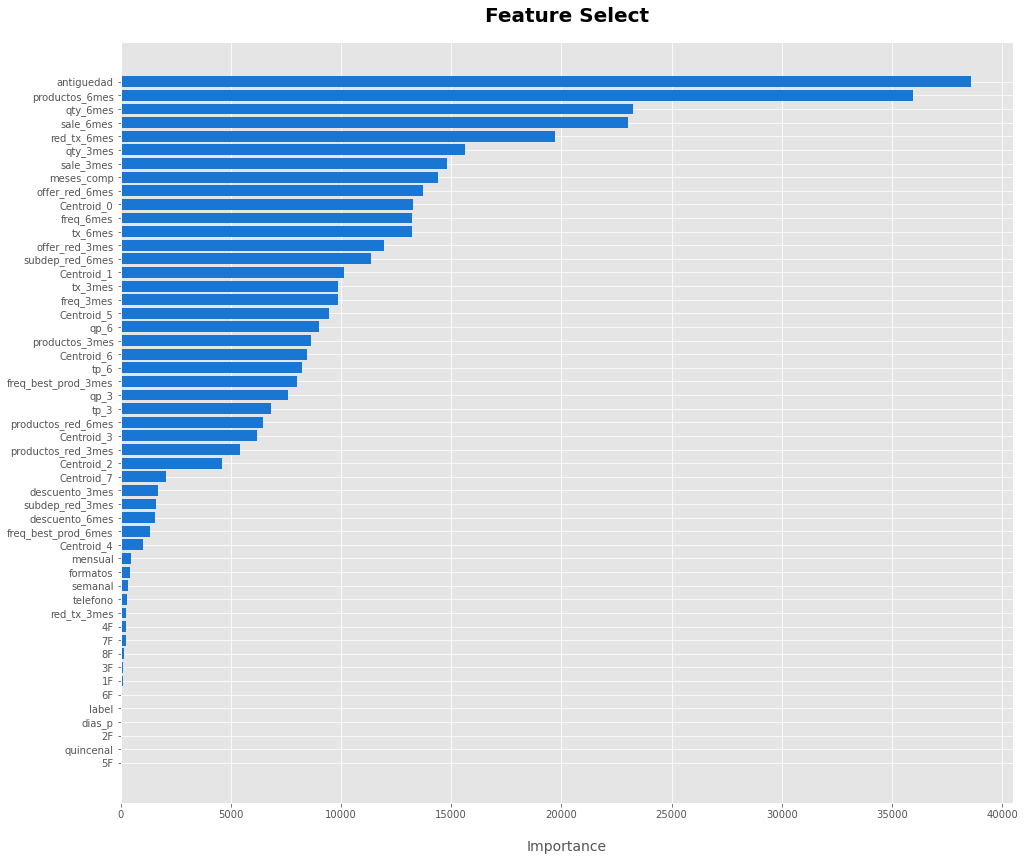

In [67]:
dset = pd.DataFrame()
dset['attr'] = scaled.columns
dset['importance'] = fs.scores_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Feature Select', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [68]:
column_names = scaled.columns
top_features = sorted(zip(column_names, fs.scores_)
                      , key=lambda x: x[1], reverse=True)
print(top_features[:10])
mejores_kbest = top_features[:10]

[('antiguedad', 38573.813361129796), ('productos_6mes', 35937.86493727315), ('qty_6mes', 23226.980622364517), ('sale_6mes', 23006.69371168675), ('red_tx_6mes', 19714.353166642788), ('qty_3mes', 15605.186699131991), ('sale_3mes', 14795.591680028176), ('meses_comp', 14411.15944149345), ('offer_red_6mes', 13726.492816964908), ('Centroid_0', 13259.272887983769)]


## Extra Trees Selection

In [69]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(max_depth=100,min_samples_leaf=5
                             ,criterion='entropy',random_state=42)

X, y = scaled,chu_train['churn']

model.fit(X, y)
print(model.feature_importances_)

[0.01780359 0.01986946 0.01519671 0.01377797 0.04082128 0.04824803
 0.02765421 0.03039122 0.00699952 0.01922768 0.09362811 0.06151511
 0.01713218 0.00415451 0.00897765 0.01168342 0.04532115 0.02021208
 0.0036063  0.00863384 0.01924128 0.04998562 0.00336438 0.12750401
 0.03609179 0.01139406 0.02713744 0.01255479 0.01082981 0.02042505
 0.01825693 0.00286769 0.00632059 0.00802614 0.00031308 0.00046763
 0.00342616 0.00019619 0.00014834 0.01020618 0.00912545 0.01459641
 0.0081128  0.01281665 0.01352683 0.0106248  0.00827755 0.0080707
 0.01135494 0.01022175 0.00966094]


In [70]:
ext=pd.DataFrame(model.feature_importances_,columns=["extratrees"])

In [71]:
column_names = scaled.columns
top_features = sorted(zip(column_names, model.feature_importances_)
                      , key=lambda x: x[1], reverse=True)
print(top_features[:26])
mejores_tree = top_features[:10]

[('antiguedad', 0.12750401430453495), ('productos_6mes', 0.09362810838324835), ('dias_p', 0.061515112188154086), ('red_tx_6mes', 0.049985621999979316), ('qty_6mes', 0.04824802746254388), ('red_tx_3mes', 0.04532114762035487), ('sale_6mes', 0.04082127929233888), ('meses_comp', 0.036091787981832275), ('freq_6mes', 0.03039122113775447), ('tx_6mes', 0.027654213764371122), ('freq_best_prod_6mes', 0.027137443664750904), ('tp_6', 0.020425045589084985), ('offer_red_6mes', 0.020212083067658593), ('qty_3mes', 0.01986946300248457), ('subdep_red_6mes', 0.019241282050785475), ('productos_3mes', 0.01922768108563663), ('qp_6', 0.018256931488642263), ('sale_3mes', 0.01780358600472162), ('offer_red_3mes', 0.017132176274448904), ('tx_3mes', 0.015196707438465558), ('semanal', 0.01459640756193128), ('freq_3mes', 0.01377797409345148), ('Centroid_1', 0.013526829889945441), ('Centroid_0', 0.012816653190830507), ('tp_3', 0.012554785818831795), ('subdep_red_3mes', 0.011683418171658558)]


[0.01780359 0.01986946 0.01519671 0.01377797 0.04082128 0.04824803
 0.02765421 0.03039122 0.00699952 0.01922768 0.09362811 0.06151511
 0.01713218 0.00415451 0.00897765 0.01168342 0.04532115 0.02021208
 0.0036063  0.00863384 0.01924128 0.04998562 0.00336438 0.12750401
 0.03609179 0.01139406 0.02713744 0.01255479 0.01082981 0.02042505
 0.01825693 0.00286769 0.00632059 0.00802614 0.00031308 0.00046763
 0.00342616 0.00019619 0.00014834 0.01020618 0.00912545 0.01459641
 0.0081128  0.01281665 0.01352683 0.0106248  0.00827755 0.0080707
 0.01135494 0.01022175 0.00966094]
suma: 0.9154458502328194


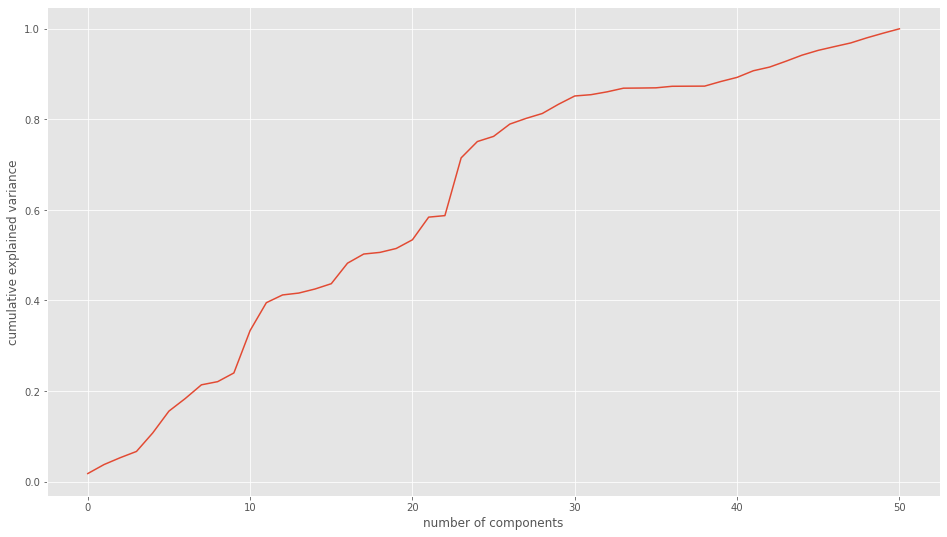

In [72]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

expl = model.feature_importances_
print(expl)
print('suma:',sum(expl[0:43]))

plt.plot(np.cumsum(model.feature_importances_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

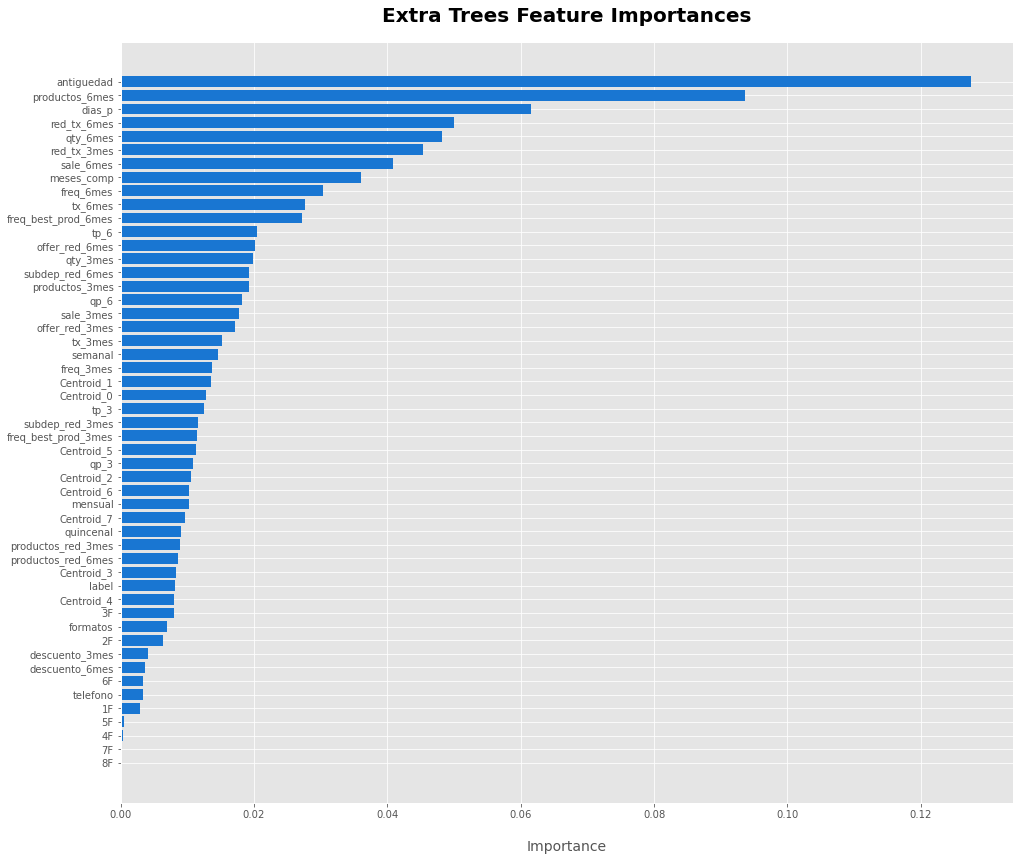

In [73]:
dset = pd.DataFrame()
dset['attr'] = scaled.columns
dset['importance'] = model.feature_importances_

dset = dset.sort_values(by='importance', ascending=True)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('Extra Trees Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

# Boruta

In [77]:
from boruta import BorutaPy
from xgboost import XGBClassifier

model_val = XGBClassifier(learning_rate=0.5, n_jobs=1,use_label_encoder=False, eval_metric = 'logloss')

boruta = BorutaPy(estimator=model_val, 
                  n_estimators='auto',max_iter=5)

boruta.fit(np.array(scaled),np.array(chu_train['churn']))

BorutaPy(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                 colsample_bylevel=1, colsample_bynode=1,
                                 colsample_bytree=1, enable_categorical=False,
                                 eval_metric='logloss', gamma=0, gpu_id=-1,
                                 importance_type=None,
                                 interaction_constraints='', learning_rate=0.5,
                                 max_delta_step=0, max_depth=6,
                                 min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=168,
                                 n_jobs=1, num_parallel_tree=1,
                                 predictor='auto', random_state=1434582003,
                                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                                 subsample=1, tree_method='exact',
                                 use_label_encoder=False, validate_paramet

In [76]:
green_area = scaled.columns[boruta.support_].to_list()
blue_area = scaled.columns[boruta.support_weak_].to_list()

print('features in gree area: ', green_area)
print('features in blue area: ', blue_area)

features in gree area:  ['sale_3mes', 'qty_3mes', 'tx_3mes', 'freq_3mes', 'sale_6mes', 'qty_6mes', 'tx_6mes', 'freq_6mes', 'productos_3mes', 'productos_6mes', 'dias_p', 'offer_red_3mes', 'red_tx_3mes', 'offer_red_6mes', 'subdep_red_6mes', 'red_tx_6mes', 'antiguedad', 'meses_comp', 'freq_best_prod_6mes', 'tp_6', 'qp_6', 'mensual', 'quincenal', 'semanal', 'Centroid_5']
features in blue area:  ['productos_red_3mes', 'subdep_red_3mes', 'freq_best_prod_3mes', 'tp_3', 'qp_3', 'label', 'Centroid_0', 'Centroid_1', 'Centroid_2', 'Centroid_3', 'Centroid_4', 'Centroid_6', 'Centroid_7']


In [78]:
len(green_area)

25

In [79]:
green_2 = ['sale_3mes', 'qty_3mes', 'tx_3mes',
           'sale_6mes', 'qty_6mes', 'tx_6mes',
           'productos_3mes', 'productos_6mes',
           'dias_p', 'offer_red_3mes',
           'descuento_3mes', 'productos_red_3mes',
           'subdep_red_3mes', 'red_tx_3mes',
           'offer_red_6mes', 'descuento_6mes',
           'productos_red_6mes', 'subdep_red_6mes',
           'red_tx_6mes', 'antiguedad', 'freq_best_prod_3mes',
           'freq_best_prod_6mes', 'qp_6',
           '1F','2F','3F','4F','5F',
           '6F', '7F', '8F', 'mensual', 'quincenal',
           'semanal','label','Centroid_0','Centroid_1',
           'Centroid_2','Centroid_3','Centroid_4',
          'Centroid_5','Centroid_6','Centroid_7']

# Pipeline

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing  import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

cat_val,disc_val = trans_data().type_features(chu_test)
chu_test = trans_data().target(chu_test)

#Se crea un pipeline para reliazar un proceso de transformación en serie
pipe = Pipeline([('trans',trans_data())
                 ,('std_scaler',StandardScaler())])
pipe_2 = Pipeline([('cluster',cluster())])


full_pipeline = ColumnTransformer([
    ('num',pipe,disc_val),
    ('cat',OneHotEncoder(),cat_val),
    ('num_2',pipe_2,feat_clus)
])


base_preparada = full_pipeline.fit_transform(chu_test)

In [81]:
base_preparada.shape

(68068, 43)

In [82]:
scaled[green_2].shape

(193552, 43)

# Reescalar Base de entrenamiento

In [83]:
from sklearn.utils import resample

base = scaled[green_2].copy().join(chu_train['churn'])
#Separate majority and minority classes
chu_majority = base[base.churn==0]
chu_minority = base[base.churn==1]
 

df_minority_upsampled = resample(chu_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=149987,    # to match majority class
                                 random_state=42) # reproducible result
#df_mayority_upsampled = resample(chu_majority, 
#                                 replace=True,     # sample with replacement
#                                 n_samples=330000,    # to match majority class
#                                 random_state=0) #
 
# Combine majority class with upsampled minority class
base = pd.concat([chu_majority,df_minority_upsampled])
 
# Display new class counts
base.churn.value_counts()

1    149987
0    149976
Name: churn, dtype: int64

# Entrenamiento del modelo

In [84]:
X_train = base[green_2]
y_train = base['churn']

X_test = pd.DataFrame(base_preparada,
                      columns = scaled[green_2].columns)
y_test = chu_test['churn']

## SGDC

In [85]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3,
                        random_state=42,penalty="l2")
sgd_clf.fit(X_train, y_train)

SGDClassifier(random_state=42)

In [86]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.88531624, 0.8875165 , 0.88758539])

In [87]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [88]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[128385,  21591],
       [ 12363, 137624]])

In [89]:
y_train_perfect_predictions = y_train 
confusion_matrix(y_train, y_train_perfect_predictions)

array([[149976,      0],
       [     0, 149987]])

In [90]:
from sklearn.metrics import precision_score, recall_score

print('precision: ' + str(precision_score(y_train, y_train_pred)))
print('recall : ' + str(recall_score(y_train, y_train_pred)))

precision: 0.8643909179411488
recall : 0.9175728563142139


In [91]:
from sklearn.metrics import f1_score

f1_score(y_train, y_train_pred)

0.8901882911494752

# Decision Tree

In [92]:
from sklearn.tree import DecisionTreeClassifier

tree_reg = DecisionTreeClassifier(max_depth=50
                                  ,min_samples_leaf=15,criterion='entropy')
tree_reg.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=50, min_samples_leaf=15)

In [93]:
# Medición 
from sklearn.model_selection import cross_val_score 
cross_val_score(tree_reg,X_train,y_train,scoring='accuracy', cv=3)

array([0.89056687, 0.89127695, 0.88726534])

In [94]:
y_train_pred_tree = cross_val_predict(tree_reg,X_train, y_train,cv=3)

In [95]:
confusion_matrix(y_train,y_train_pred_tree)

array([[131124,  18852],
       [ 14221, 135766]])

In [96]:
y_train_perfect_predictions = y_train 
confusion_matrix(y_train, y_train_perfect_predictions)

array([[149976,      0],
       [     0, 149987]])

In [97]:
print('precision: ' + str(precision_score(y_train, y_train_pred_tree)))
print('recall : ' + str(recall_score(y_train, y_train_pred_tree)))

precision: 0.8780737042258987
recall : 0.9051851160433905


In [98]:
f1_score(y_train, y_train_pred_tree)

0.8914233187242495

# Radom Forest

In [99]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(max_depth=100,min_samples_leaf=4
                                    ,criterion='entropy',max_leaf_nodes=15)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=100, max_leaf_nodes=15,
                       min_samples_leaf=4)

In [100]:
cross_val_score(forest_clf,X_train,y_train,scoring='accuracy', cv=3)

array([0.81861823, 0.81716806, 0.81659616])

In [101]:
y_train_pred_forest = cross_val_predict(forest_clf,X_train, y_train,cv=3)

In [102]:
confusion_matrix(y_train,y_train_pred_forest)

array([[116556,  33420],
       [ 21110, 128877]])

In [103]:
print('precision: ' + str(precision_score(y_train, y_train_pred_forest)))
print('recall : ' + str(recall_score(y_train, y_train_pred_forest)))

precision: 0.7940812214643523
recall : 0.8592544687206225


In [104]:
f1_score(y_train, y_train_pred_forest)

0.8253833049403748

In [105]:
y_scores_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                             method="predict_proba")
#y_scores = forest_clf.predict_proba(X_test)
y_scores_forest = y_scores_forest[:,1]
print(y_scores_forest)

[0.3189375  0.27888919 0.13466935 ... 0.79236963 0.59064958 0.70098395]


In [106]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_forest)

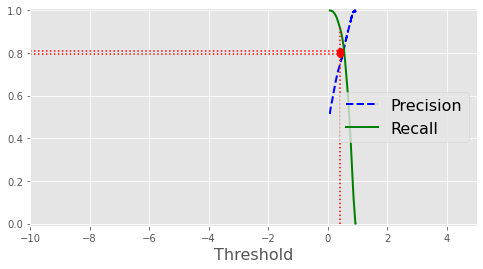

In [107]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-10, 5, -.01, 1.01])             

recall_90_precision = recalls[np.argmax(precisions >= 0.83)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.74)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.92], "r:")                
plt.plot([-10, threshold_90_precision], [0.81, 0.81], "r:")                               
plt.plot([-10, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.81], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                             
plt.show()

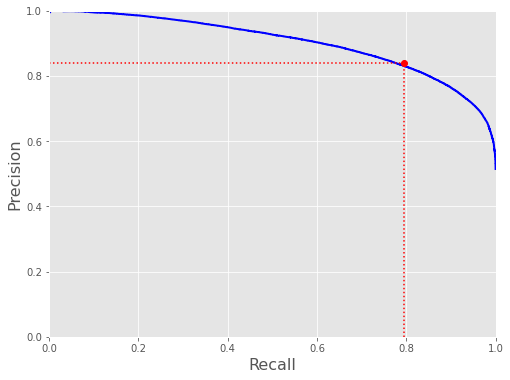

In [108]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.84], "r:")
plt.plot([0.0, recall_90_precision], [0.84, 0.84], "r:")
plt.plot([recall_90_precision], [0.84], "ro")
plt.show()

In [109]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores_forest)

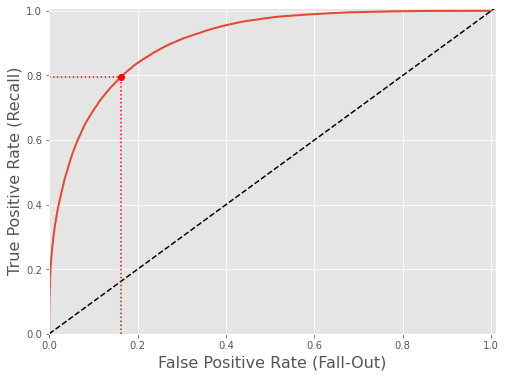

In [110]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1.01], [0, 1.01], 'k--') # dashed diagonal
    plt.axis([0, 1.01, 0, 1.01])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                           

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]          
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")              
plt.show()

# XGBoost

In [111]:
from xgboost import XGBClassifier

model = XGBClassifier(n_estimators=300, learning_rate=0.3,
                      n_jobs=1,use_label_encoder=False, 
                      eval_metric = 'logloss'
                      ,max_depth=6)
model.fit(X_train, y_train, 
             early_stopping_rounds=4, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [112]:
cross_val_score(model,X_train,y_train,scoring='accuracy', cv=3)

array([0.94262311, 0.94088291, 0.94194245])

In [113]:
y_train_pred_xg = cross_val_predict(model,X_train, y_train,cv=3)

In [114]:
confusion_matrix(y_train,y_train_pred_xg)

array([[137607,  12369],
       [  5084, 144903]])

In [115]:
print('precision: ' + str(precision_score(y_train, y_train_pred_xg)))
print('recall : ' + str(recall_score(y_train, y_train_pred_xg)))

precision: 0.9213528155043491
recall : 0.9661037289898458


In [116]:
f1_score(y_train, y_train_pred_xg)

0.9431977582430457

In [117]:
y_scores_xg = cross_val_predict(model, X_train, y_train, cv=3,
                             method="predict_proba")
#y_scores = forest_clf.predict_proba(X_test)
y_scores_xg = y_scores_xg[:,1]
print(y_scores_xg)

[3.4741346e-02 7.0593923e-02 2.7481687e-07 ... 7.6962906e-01 9.9800366e-01
 9.3145496e-01]


In [118]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores_xg)

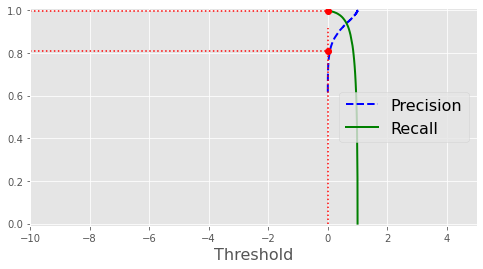

In [119]:
recall_90_precision = recalls[np.argmax(precisions >= 0.83)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.74)]


plt.figure(figsize=(8, 4))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.92], "r:")                
plt.plot([-10, threshold_90_precision], [0.81, 0.81], "r:")                                
plt.plot([-10, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.81], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                                     
plt.show()

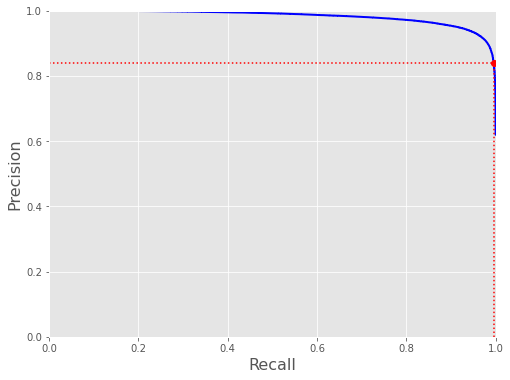

In [120]:
plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.84], "r:")
plt.plot([0.0, recall_90_precision], [0.84, 0.84], "r:")
plt.plot([recall_90_precision], [0.84], "ro")
plt.show()

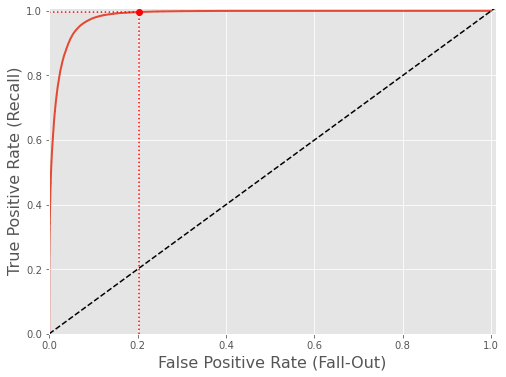

In [121]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores_xg)

plt.figure(figsize=(8, 6))                                    
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  
plt.plot([fpr_90], [recall_90_precision], "ro")                                     
plt.show()

# Grid Search

In [122]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[300,350,400], 'learning_rate':[0.3], 'n_jobs':[1],'max_depth':[5,6,7]}
]

grid_search = GridSearchCV(model,param_grid, cv =5, scoring='precision',return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=0, gpu_id=-1,
                                     importance_type=None,
                                     interaction_constraints='',
                                     learning_rate=0.3, max_delta_step=0,
                                     max_depth=6, min_child_weight=1,
                                     missing=nan, monotone_constraints='()',
                                     n...ors=300, n_jobs=1,
                                     num_parallel_tree=1, predictor='auto',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
 

In [123]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [124]:
model = XGBClassifier(n_estimators=400, learning_rate=0.3,
                      n_jobs=1,use_label_encoder=False, 
                      eval_metric = 'logloss',
                      max_depth=7)
model.fit(X_train, y_train, 
             early_stopping_rounds=10, 
             eval_set=[(X_test, y_test)], 
             verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

# Test

## SGDC

In [125]:
cross_val_score(sgd_clf,X_test,y_test,scoring='accuracy', cv=3)

array([0.89334509, 0.91357045, 0.90572524])

In [126]:
y_test_pred_sgd = cross_val_predict(sgd_clf,X_test, y_test,cv=3)

In [127]:
confusion_matrix(y_test,y_test_pred_sgd)

array([[50968,  2376],
       [ 4144, 10580]])

In [128]:
print('precision: ' + str(precision_score(y_test, y_test_pred_sgd)))
print('recall : ' + str(recall_score(y_test, y_test_pred_sgd)))

precision: 0.8166100648348256
recall : 0.7185547405596305


In [129]:
f1_score(y_test, y_test_pred_sgd)

0.7644508670520233

## Decision Tree

In [130]:
cross_val_score(tree_reg,X_test,y_test,scoring='accuracy', cv=3)

array([0.87919788, 0.88060294, 0.88020627])

In [131]:
y_test_pred_tree = cross_val_predict(tree_reg,X_test, y_test,cv=3)

In [132]:
confusion_matrix(y_test,y_test_pred_tree)

array([[49881,  3463],
       [ 4704, 10020]])

In [133]:
print('precision: ' + str(precision_score(y_test, y_test_pred_tree)))
print('recall : ' + str(recall_score(y_test, y_test_pred_tree)))

precision: 0.7431580508788845
recall : 0.680521597392013


In [134]:
f1_score(y_test, y_test_pred_tree)

0.710461942071117

## RandomForest

In [135]:
cross_val_score(forest_clf,X_test,y_test,scoring='accuracy', cv=3)

array([0.86562362, 0.86552955, 0.86539733])

In [136]:
y_test_pred_forest = cross_val_predict(forest_clf,X_test, y_test,cv=3)

In [137]:
confusion_matrix(y_test,y_test_pred_forest)

array([[52046,  1298],
       [ 7847,  6877]])

In [138]:
print('precision: ' + str(precision_score(y_test, y_test_pred_forest)))
print('recall : ' + str(recall_score(y_test, y_test_pred_forest)))

precision: 0.8412232415902141
recall : 0.46706058136375983


In [139]:
f1_score(y_test, y_test_pred_forest)

0.6006375824271802

## XGBoost

In [140]:
cross_val_score(model,X_test,y_test,scoring='accuracy', cv=3)

array([0.92340238, 0.92423641, 0.9249416 ])

In [141]:
y_test_pred_xg = cross_val_predict(model,X_test, y_test,cv=3)

In [142]:
confusion_matrix(y_test,y_test_pred_xg)

array([[51183,  2161],
       [ 2999, 11725]])

In [143]:
print('precision: ' + str(precision_score(y_test, y_test_pred_xg)))
print('recall : ' + str(recall_score(y_test, y_test_pred_xg)))

precision: 0.8443756301310673
recall : 0.7963189350719913


In [144]:
f1_score(y_test, y_test_pred_xg)

0.8196434813002448

# Validación

In [145]:
chu_val = trans_data().target(chu_val)
base_val =full_pipeline.fit_transform(chu_val)
X_val = pd.DataFrame(base_val,columns = scaled[green_2].columns)
y_val = chu_val['churn']

In [146]:
cross_val_score(model,X_val,y_val,scoring='accuracy', cv=3)

array([0.91814068, 0.9184492 , 0.92472234])

In [147]:
y_val_pred_xg = cross_val_predict(model,X_val, y_val,cv=3)

In [148]:
confusion_matrix(y_val,y_val_pred_xg)

array([[21976,   933],
       [ 1388,  4875]])

In [149]:
print('precision: ' + str(precision_score(y_val, y_val_pred_xg)))
print('recall : ' + str(recall_score(y_val, y_val_pred_xg)))

precision: 0.8393595041322314
recall : 0.7783809675874181


In [150]:
f1_score(y_val, y_val_pred_xg)

0.8077209841769529


-----------------------------------------------------------------------------------
                      Reporte de Clasficación
-----------------------------------------------------------------------------------

Accuracy Score: 0.9
------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     22909
           1       0.80      0.74      0.77      6263

    accuracy                           0.90     29172
   macro avg       0.86      0.84      0.85     29172
weighted avg       0.90      0.90      0.90     29172

------------------------------------------------------------------------------------


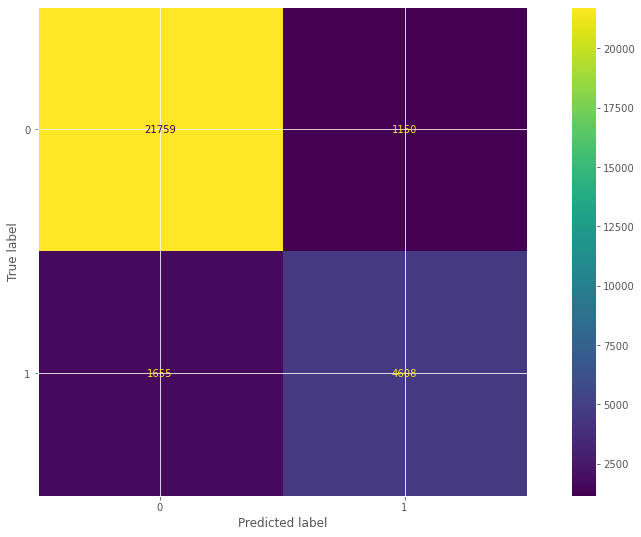

In [151]:
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
print('''
-----------------------------------------------------------------------------------
                      Reporte de Clasficación
-----------------------------------------------------------------------------------
''')
print('Accuracy Score:', round(accuracy_score(y_val,model.predict(X_val)),2))
print('------------------------------------------------------------------------------------')
print(classification_report(y_val,model.predict(X_val)))
print('------------------------------------------------------------------------------------')
plot_confusion_matrix(model,X_val,y_val);

Text(0, 0.5, 'Número de clientes')

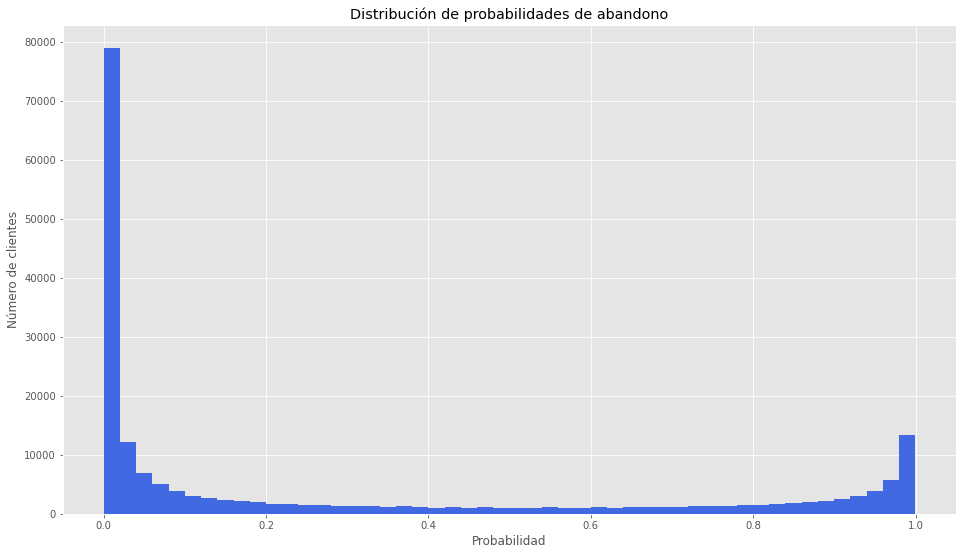

In [152]:
y_scores_xg = model.predict_proba(scaled[green_2])
y_scores_xg = y_scores_xg[:,1]
pd.DataFrame(y_scores_xg).hist(bins=50,color='royalblue')
plt.title('Distribución de probabilidades de abandono')
plt.xlabel('Probabilidad')
plt.ylabel('Número de clientes')

Text(0, 0.5, 'Número de clientes')

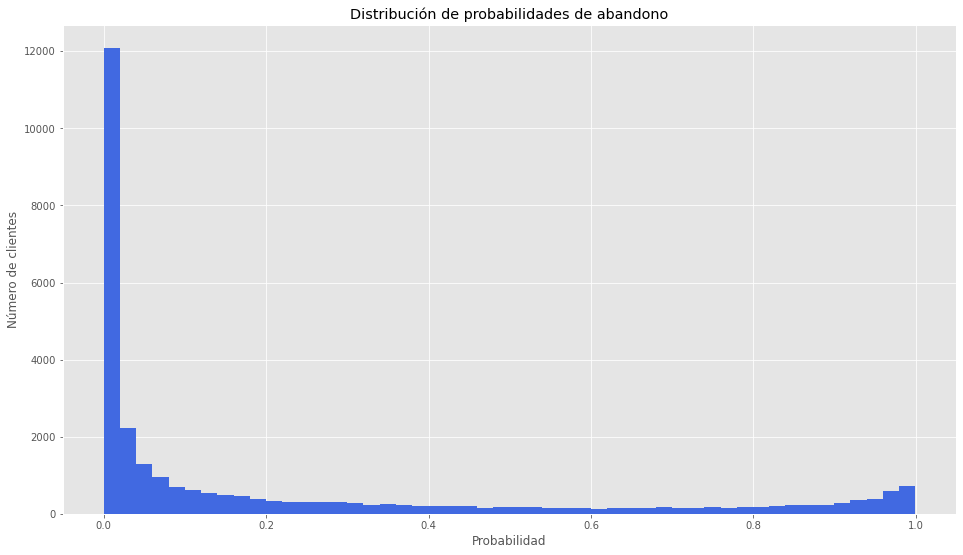

In [153]:
y_scores_xg = model.predict_proba(X_val)
y_scores_xg = y_scores_xg[:,1]
pd.DataFrame(y_scores_xg).hist(bins=50,color='royalblue')
plt.title('Distribución de probabilidades de abandono')
plt.xlabel('Probabilidad')
plt.ylabel('Número de clientes')

In [154]:
y_scores_xg = cross_val_predict(model, X_val, y_val, cv=3,
                             method="predict_proba")
#y_scores = forest_clf.predict_proba(X_test)
y_scores_xg = y_scores_xg[:,1]

In [155]:
precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores_xg)

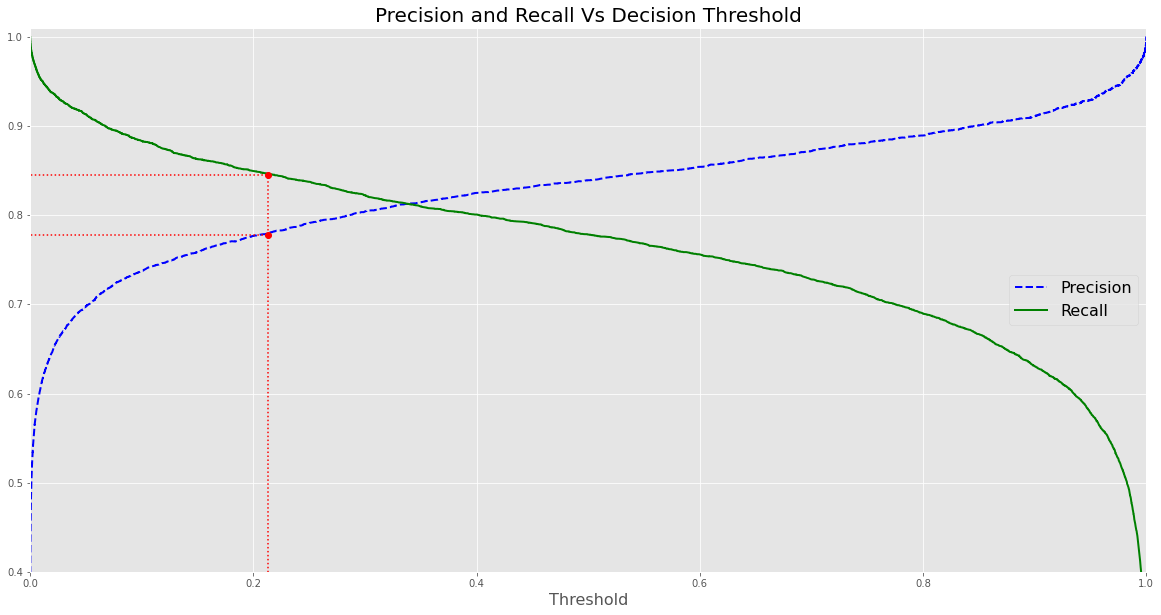

In [156]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                              
    plt.axis([-0, 1, .4, 1.01])             

recall_90_precision = recalls[np.argmax(precisions >= 0.84)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.78)]


plt.figure(figsize=(20, 10))                                                                  
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.845], "r:")                
plt.plot([-10, threshold_90_precision], [0.845, 0.845], "r:")                                
plt.plot([-10, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.845], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")  
plt.title('Precision and Recall Vs Decision Threshold',fontsize=20)
plt.show()

# Importancia de variables

In [157]:
model.feature_importances_

array([0.01378029, 0.01840239, 0.03053436, 0.02474807, 0.00907856,
       0.03904992, 0.0257683 , 0.2022491 , 0.04144022, 0.05171243,
       0.0098479 , 0.00679872, 0.00615906, 0.1039296 , 0.02173397,
       0.008143  , 0.010234  , 0.00908277, 0.0470111 , 0.12396993,
       0.03509578, 0.02654331, 0.00506726, 0.00505959, 0.00301611,
       0.00423401, 0.        , 0.00240393, 0.00348377, 0.00229229,
       0.00552977, 0.01662254, 0.00880278, 0.01329989, 0.00510215,
       0.00324929, 0.00749824, 0.00429726, 0.00390849, 0.00448497,
       0.02462748, 0.00672103, 0.00498646], dtype=float32)

Text(0.5, 0, 'Xgboost Feature Importance')

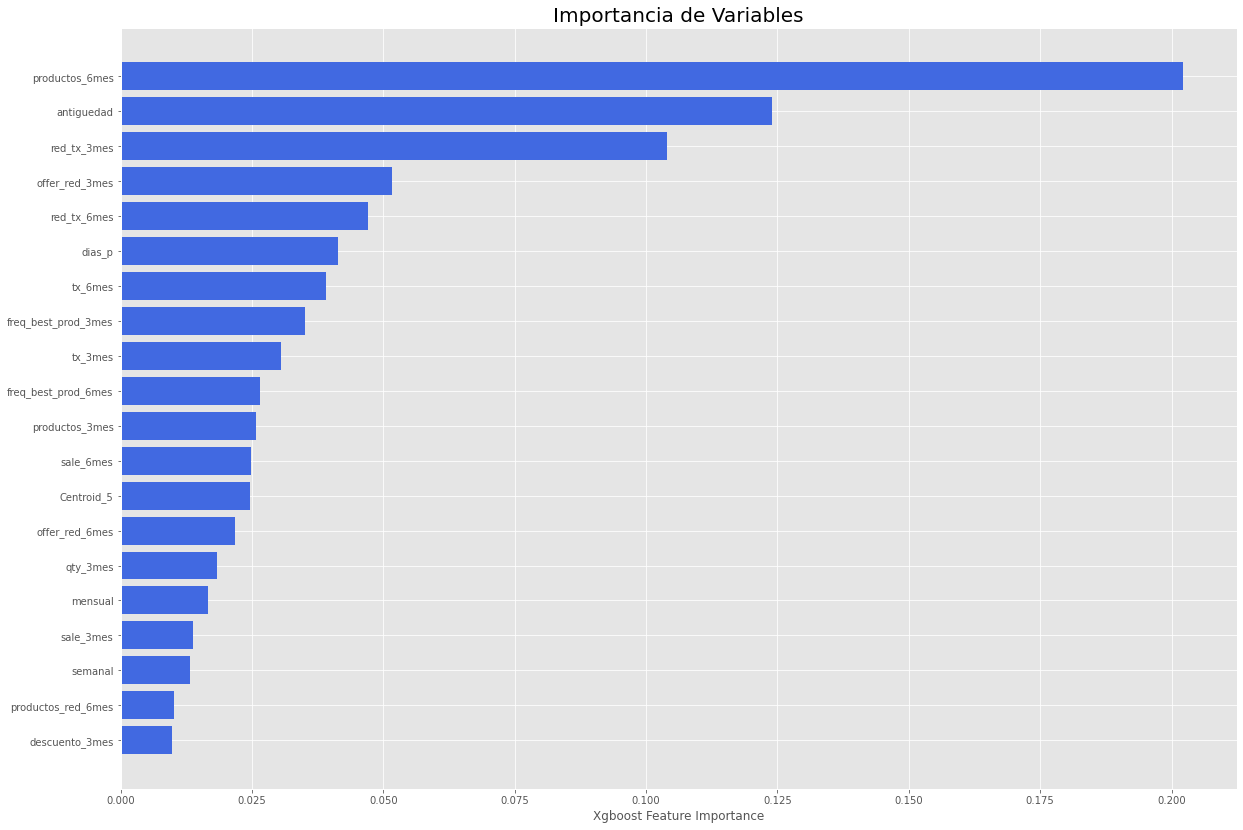

In [158]:
sorted_idx = model.feature_importances_.argsort()[-20:]
plt.figure(figsize=(20,14))
plt.barh(X_val.columns[sorted_idx], model.feature_importances_[sorted_idx],color='royalblue')
plt.title('Importancia de Variables',fontsize=20)
plt.xlabel("Xgboost Feature Importance")

In [160]:
import shap

shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_val)

Customer_1 = 77

shap.initjs()
index_choice = X_val.index.get_loc(Customer_1)
shap.force_plot(shap_explainer.expected_value, shap_values[index_choice], X_val.iloc[index_choice],link='logit')

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


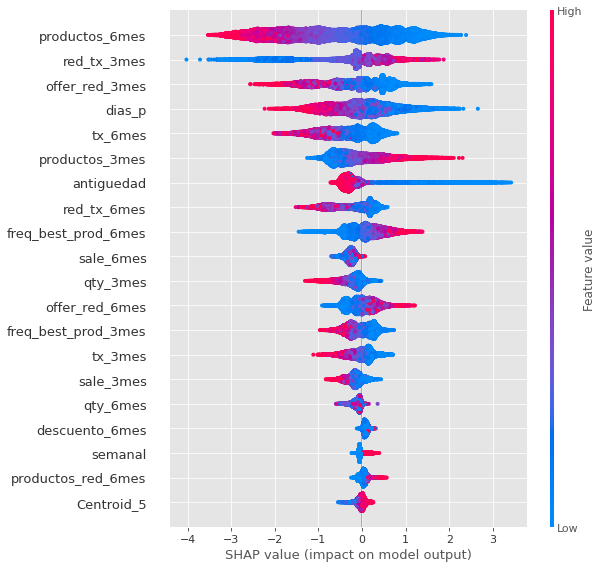

In [161]:
shap.summary_plot(shap_values, X_val, X_val.columns)

# Guardar modelo

In [162]:
import joblib
joblib.dump(model,'churn_model.pkl')

['churn_model.pkl']

In [163]:
churn_model = joblib.load('churn_model.pkl')